In [1]:
import pandas as pd
from datetime import date, datetime, timedelta
import pickle
import numpy as np
from math import sqrt
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import math

<h3> Hotspot calculation (Also used in GUI) <h3>

In [2]:
def open_file():
    try:
        data_file = pd.read_csv(DEFAULT_FILE_PATH + CSV_FILE_EXTENSION)
    except:
        print("File not found")
        return pd.DataFrame()
    return data_file

In [3]:
# Define file variables
DEFAULT_FILE_PATH = "CrimeGUI/data"
CSV_FILE_EXTENSION = ".csv"
DATA_FILE = pd.DataFrame()
FILTERED_DATA = pd.DataFrame()
DATA_FILE = open_file()
FIRST_DATE = datetime.strptime(DATA_FILE['Date'].iloc[0], '%d/%m/%Y')
LAST_DATE = datetime.strptime(DATA_FILE['Date'].iloc[len(DATA_FILE) - 1], '%d/%m/%Y')
MODEL_FEATURE_SEPARATOR = "_"
MODEL_PATH = "CrimeGUI/Models/"
COMMA_SPACE = ", "
INCIDENT_COL_KEY = "Todays Reports"
NEIGHBOURHOOD_COL_KEY = "Neighborhood"
DATE_COL_KEY = "Date"

In [4]:
# Define feature selection variables
F_REGRESSION_NAME = "F-Regression"
F_REGRESSION_FILE_TAG = "f_regression"
CHI2_NAME = "Chi-Squared"
CHI2_FILE_TAG = "chi2"
ADABOOST_NAME = "AdaBoost"
ADABOOST_FILE_TAG = "adaboost"
EQUAL_DATA_NAME = "Equal Selection"
EQUAL_DATA_FILE_TAG = "equal_crime_and_business"
ALL_BUS_NAME = "All Business"
ALL_BUS_FILE_TAG = "all_business"
FEATURE_SELECTION = [F_REGRESSION_NAME, CHI2_NAME, ADABOOST_NAME, EQUAL_DATA_NAME, ALL_BUS_NAME]
FEATURES = {
    F_REGRESSION_NAME : ['Reports 1 day ago', 'Reports 2 days ago', 'Reports 3 days ago',
                       'Reports 4 days ago', 'Reports 5 days ago', 'Reports 6 days ago',
                      'Reports 7 days ago','Reports 14 days ago','Reports 30 days ago','Reports 365 days ago'],
    CHI2_NAME : ['South of Market', 'Mission', 'Tenderloin', 'Number of businesses', 
               'Downtown / Union Square', 'Civic Center', 'Reports 365 days ago',
               'Reports 1 day ago','Reports 2 days ago','Reports 14 days ago'],
    ADABOOST_NAME : ['Reports 365 days ago', 'Reports 1 day ago', 'Reports 14 days ago', 'Reports 3 days ago', 
               'Reports 2 days ago', 'Reports 7 days ago', 'Number of businesses',
               'Reports 4 days ago','Reports 5 days ago','Closures 365 days ago'],
    EQUAL_DATA_NAME : ['Number of businesses', 'Last 28 days closures', 'Last 7 days openings',
                          'Last 14 days closures', 'Last 7 days closures','Reports 1 day ago',
                      'Reports 2 days ago', 'Reports 4 days ago', 'Reports 30 days ago', 'Reports 7 days ago'],
    ALL_BUS_NAME : ['Number of businesses', 'Last 28 days closures', 'Last 7 days openings',
                          'Last 14 days closures', 'Last 7 days closures','Number of openings',
                   'Openings 4 days ago','Openings 1 day ago', 'Openings 7 days ago', 'Openings 2 days ago']
    }
FEATURE_FILE_TAGS = {
    F_REGRESSION_NAME : F_REGRESSION_FILE_TAG,
    CHI2_NAME : CHI2_FILE_TAG,
    ADABOOST_NAME : ADABOOST_FILE_TAG,
    EQUAL_DATA_NAME : EQUAL_DATA_FILE_TAG,
    ALL_BUS_NAME : ALL_BUS_FILE_TAG
    }
FEATURE_NAMES_BY_FILE_TAG = {
    F_REGRESSION_FILE_TAG : F_REGRESSION_NAME,
    CHI2_FILE_TAG : CHI2_NAME,
    ADABOOST_FILE_TAG : ADABOOST_NAME,
    EQUAL_DATA_FILE_TAG : EQUAL_DATA_NAME,
    ALL_BUS_FILE_TAG : ALL_BUS_NAME
}

In [5]:
# Define model variables
ANN_NAME = "Multi-Layer\nPerceptron"
ANN_FILE_TAG = "multi_layer_perceptron"
DECISION_TREE_NAME = "Decision Tree"
DECISION_TREE_FILE_TAG = "decision_tree"
ELASTIC_NET_NAME = "Elastic Net"
ELASTIC_NET_FILE_TAG = "elastic_net"
LASSO_NAME = "Lasso"
LASSO_FILE_TAG = "lasso"
LINERAR_REGRESSION_NAME = "Linear \nRegression"
LINERAR_REGRESSION_FILE_TAG = "linear_regression"
RANDOM_FOREST_NAME = "Random \nForest"
RANDOM_FOREST_FILE_TAG = "random_forest"
RIDGE_REGRESSION_NAME = "Ridge \nRegression"
RIDGE_REGRESSION_FILE_TAG = "ridge_regression"
SVM_NAME = "SVM"
SVM_FILE_TAG = "svm"
MODELS = [ANN_NAME,
          DECISION_TREE_NAME,
          ELASTIC_NET_NAME,
          LASSO_NAME,
          LINERAR_REGRESSION_NAME,
          RANDOM_FOREST_NAME,
          RIDGE_REGRESSION_NAME,
          SVM_NAME]
MODEL_FILE_TAGS = {
    ANN_NAME : ANN_FILE_TAG,
    DECISION_TREE_NAME : DECISION_TREE_FILE_TAG,
    ELASTIC_NET_NAME : ELASTIC_NET_FILE_TAG,
    LASSO_NAME : LASSO_FILE_TAG,
    LINERAR_REGRESSION_NAME: LINERAR_REGRESSION_FILE_TAG,
    RANDOM_FOREST_NAME: RANDOM_FOREST_FILE_TAG,
    RIDGE_REGRESSION_NAME: RIDGE_REGRESSION_FILE_TAG,
    SVM_NAME : SVM_FILE_TAG
    }
MODEL_NAMES_BY_FILE_TAG = {
    ANN_FILE_TAG : ANN_NAME,
    DECISION_TREE_FILE_TAG : DECISION_TREE_NAME,
    ELASTIC_NET_FILE_TAG : ELASTIC_NET_NAME,
    LASSO_FILE_TAG : LASSO_NAME,
    LINERAR_REGRESSION_FILE_TAG : LINERAR_REGRESSION_NAME,
    RANDOM_FOREST_FILE_TAG: RANDOM_FOREST_NAME,
    RIDGE_REGRESSION_FILE_TAG : RIDGE_REGRESSION_NAME,
    SVM_FILE_TAG : SVM_NAME
}

In [6]:
PARENT_NEIGHBOURHOODS = {
    "Central Waterfront" : ["Dogpatch"],
    "Eureka Valley" : ["Dolores Heights","Castro"],
    "Buena Vista" : ["Ashbury Heights"],
    "Cole Valley" : ["Parnassus Heights"],
    "Bayview" : ["Apparel City", "Produce Market"],
    "Russian Hill" : ["Aquatic Park / Ft. Mason"],
    "North Beach" : ["Bret Harte"],
    "Western Addition" : ["Cathedral Hill", "Japantown"],
    "Downtown / Union Square" : ["Fairmount", "Chinatown", "Lower Nob Hill", "Polk Gulch"],
    "Mission Terrace" : ["Cayuga"],
    "Northern Waterfront" : ["Fishermans Wharf"],
    "Bernal Heights" : ["Holly Park", "Peralta Heights", "St. Marys Park"],
    "Hunters Point" : ["India Basin"],
    "Forest Hill" : ["Laguna Honda"],
    "Hayes Valley" : ["Lower Haight"],
    "Portola" : ["McLaren Park", "University Mound"],
    "South of Market" : ["Mint Hill"],
    "Stonestown" : ["Parkmerced"],
    "Presidio Heights" : ["Presidio Terrace"],
    "South Beach" : ["Rincon Hill"],
    "Potrero Hill" : ["Showplace Square"],
    "Visitacion Valley" : ["Sunnydale"],
    "Lincoln Park / Ft. Miley" : ["Sutro Heights"],
    "Cow Hollow" : ["Union Street"]
    }

In [7]:
def get_hotspots(data, model_key, features_key,calendar_date):
    x_data = data.loc[data[DATE_COL_KEY].str.contains(calendar_date)]
    neighbourhoods_data = pd.DataFrame(x_data[NEIGHBOURHOOD_COL_KEY])
    neighbourhoods_data.reset_index(drop=True, inplace=True)
    y_data = pd.DataFrame(x_data[INCIDENT_COL_KEY])
    y_data.reset_index(drop=True, inplace=True)
    features_selected = FEATURES[features_key]
    x_data = x_data[features_selected]
    return load_model(x_data, y_data, neighbourhoods_data, model_key, features_key)

In [8]:
def load_model(x_data, y_data, neighbourhoods_data, model_key, features_key):
    model_tag = MODEL_FILE_TAGS[model_key]
    feature_tag = FEATURE_FILE_TAGS[features_key]
    file_path = MODEL_PATH + model_tag + MODEL_FEATURE_SEPARATOR + feature_tag
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
        return make_prediction(model, x_data, y_data, neighbourhoods_data)

In [9]:
def make_prediction(model, x_data, y_data, neighbourhoods_data):
    y_predict = model.predict(x_data)
    y_actual,y_predict,neighbourhoods_data = merge_sub_neighbourhoods(y_data,y_predict,neighbourhoods_data)
    total_predictions = len(y_predict)
    neighbourhoods_data.reset_index(drop=True, inplace=True)
    prediction_neighbourhoods = neighbourhoods_data[NEIGHBOURHOOD_COL_KEY].to_numpy()
    actual_neighbourhoods = prediction_neighbourhoods.copy()
    indexes = y_actual.argsort()
    y_actual = np.flip(y_actual[indexes])
    actual_neighbourhoods = np.flip(actual_neighbourhoods[indexes])
    indexes = y_predict.argsort()
    y_predict = np.flip(y_predict[indexes])
    prediction_neighbourhoods = np.flip(prediction_neighbourhoods[indexes])
    return y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods

In [10]:
def get_non_negative_value(value):
    if value < 0:
        return 0
    else:
        return value

In [11]:
def merge_sub_neighbourhoods(y_data,y_predict,neighbourhoods_data):
    y_data = pd.DataFrame(y_data).to_numpy().flatten()
    indexes_to_remove = []
    for parent_key in PARENT_NEIGHBOURHOODS:
        parent_index = neighbourhoods_data.index[neighbourhoods_data[NEIGHBOURHOOD_COL_KEY] == parent_key].tolist()[0]
        y_predict_parent_value = get_non_negative_value(y_predict[parent_index])
        y_data_parent_value = get_non_negative_value(y_data[parent_index])
        for sub_neighbourhood in PARENT_NEIGHBOURHOODS[parent_key]:
            sub_neighbourhood_index = neighbourhoods_data.index[neighbourhoods_data[NEIGHBOURHOOD_COL_KEY] == sub_neighbourhood].tolist()[0]
            indexes_to_remove.append(sub_neighbourhood_index)
            y_predict_sub_neighbourhood_value = get_non_negative_value(y_predict[sub_neighbourhood_index])
            y_predict_parent_value = y_predict_parent_value + y_predict_sub_neighbourhood_value
            y_data_sub_neighbourhood_value = get_non_negative_value(y_data[sub_neighbourhood_index])
            y_data_parent_value = y_data_parent_value + y_data_sub_neighbourhood_value
        y_predict[parent_index] = y_predict_parent_value
        y_data[parent_index] = y_data_parent_value
    neighbourhoods_data = neighbourhoods_data.drop(neighbourhoods_data.index[indexes_to_remove])
    indexes_to_remove.sort(reverse=True)
    for index in indexes_to_remove:
        y_predict = np.delete(y_predict,index)
        y_data = np.delete(y_data,index)
    return y_data,y_predict,neighbourhoods_data 

<h3>Evaluation <h3>

In [12]:
def calculate_accuracy(y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods,num_hotspots):
    total_predictions = len(y_predict)
    predicted_hotspots, actual_hotspots = determine_hotspots(y_actual, 
                                                             actual_neighbourhoods, 
                                                             prediction_neighbourhoods,
                                                            num_hotspots)
    num_predictions = len(predicted_hotspots)
    classification_scores = calculate_standard_scores(num_predictions,
                                                      predicted_hotspots,
                                                      actual_hotspots,
                                                      total_predictions)
    misclassification_scores = get_missed_incidents(predicted_hotspots, 
                                                    actual_hotspots, 
                                                    y_actual, 
                                                    y_predict,
                                                    num_predictions,
                                                    actual_neighbourhoods)
    return classification_scores + misclassification_scores

In [13]:
def get_missed_incidents(predicted_hotspots, actual_hotspots, y_actual, y_predict,num_predictions,actual_neighbourhoods):
    incidents_correct = 0
    incidents_missed = 0
    additional_incidents_caught = 0
    for neighbourhood in predicted_hotspots:
        index = np.where(actual_neighbourhoods == neighbourhood)[0]
        #print(y_actual)
        value = y_actual[index]
        #print(value)
        if neighbourhood in actual_hotspots:
            incidents_correct += value
        else:
            additional_incidents_caught += value
    i = 0
    i_limit = 0
    lowest_actual = y_actual[num_predictions-1]
    while i < num_predictions:
        if y_actual[i] != lowest_actual:
            neighbourhood = actual_hotspots[i]
            if neighbourhood not in predicted_hotspots:
                index = np.where(actual_neighbourhoods == neighbourhood)[0]
                value = y_actual[index]
                incidents_missed += value
            i += 1
        else:
            i_limit = i
            i = num_predictions
    i = i_limit
    remaining_hotspots_to_find = num_predictions - i
    hotspots_found = 0
    while i < len(actual_hotspots):
        neighbourhood = actual_hotspots[i]
        if neighbourhood in predicted_hotspots:
            hotspots_found += 1
        i += 1
    num_lowest_value_hotspots_missing = remaining_hotspots_to_find - hotspots_found
    lowest_values_missed = lowest_actual * num_lowest_value_hotspots_missing
    incidents_missed += lowest_values_missed
    total_actual_hotspots = incidents_correct + incidents_missed
    net_missed = incidents_missed - additional_incidents_caught
    misclassification_severity = net_missed / total_actual_hotspots
    return [misclassification_severity]

In [14]:
def determine_hotspots(y_actual, actual_neighbourhoods, prediction_neighbourhoods,num_hotspots):
    predicted_hotspots = prediction_neighbourhoods[:num_hotspots]
    actual_hotspots = actual_neighbourhoods[:num_hotspots]
    lowest_hotspot_value = y_actual[num_hotspots-1]
    i = num_hotspots
    while i < len(actual_neighbourhoods):
        if y_actual[i] == lowest_hotspot_value:
            np.append(actual_hotspots,actual_neighbourhoods[i])
            i += 1
        else:
            i = len(actual_neighbourhoods)
    return predicted_hotspots, actual_hotspots

In [15]:
def calculate_standard_scores(num_predictions,predicted_hotspots,actual_hotspots,total_predictions):
    #true positives
    tp = 0
    #false positives
    fp = 0
    for i in range(num_predictions):
        if predicted_hotspots[i] in actual_hotspots:
            tp += 1
        else:
            fp +=1
    #true negatives
    tn = total_predictions-num_predictions-fp
    #false negatives
    fn = fp
    #sensitivity/recall
    sensitivity = 0
    if tp + fn != 0:
        sensitivity = tp / (tp + fn)
    #specificity
    specificity = 0
    if tn + fp !=0:
        specificity = tn / (tn + fp)
    #precision
    precision = 0
    if tp + fp !=0:
        precision = tp / (tp + fp)
    #f1 - incorporates both sensitivity/recall and precision
    f1 = 0
    if precision + sensitivity != 0:
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    #matthews correlation coefficient
    mcc = 0
    if sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn+fn)) != 0:
        mcc = ((tp * tn) - (fp * fn)) / (sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn+fn)))
    return [sensitivity, specificity, precision, f1, mcc]

In [16]:
def get_results(num_hotspots):
    all_scores = {}
    for score_key in SCORE_KEYS:
        all_scores[score_key] = []
    algorithm_names = []
    for model_key in MODELS:
        print(model_key)
        for feature_key in FEATURES:
            print(feature_key)
            scores = score_algorithm(model_key, feature_key,num_hotspots)
            for score_key in SCORE_KEYS:
                all_scores[score_key].append(scores[score_key])
            algorithm_names.append(model_key + "\n" + feature_key)
    return all_scores, algorithm_names

In [17]:
def score_algorithm(model_key, feature_key,num_hotspots):
    start_date = FIRST_DATE
    all_scores = {}
    for score_key in SCORE_KEYS:
        all_scores[score_key] = []
    while start_date <= LAST_DATE:
        y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods = get_hotspots(DATA_FILE, 
                                                                                model_key, 
                                                                                feature_key, 
                                                                                str(start_date.strftime("%d/%m/%Y")))
        results = calculate_accuracy(y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods,num_hotspots)
        for i in range(len(SCORE_KEYS)):
            all_scores[SCORE_KEYS[i]].append(results[i])
        start_date += timedelta(days=1)
    averages = {}
    for score_key in SCORE_KEYS:
        averages[score_key] = sum(all_scores[score_key]) / len (all_scores[score_key])
    return averages

In [18]:
def best_x_scores(score_metric,x,algorithms,results,num_hotspots):
    all_labels = algorithms.copy()
    x_labels = []
    best_scores = []
    scores = results[score_metric].copy()
    num_scores = len(scores)
    x = validate_x(num_scores,x)
    i = 0
    while i < x:
        if HIGHEST_IS_BEST[score_metric]:
            index = np.argmax(scores)
        else:
            index = np.argmin(scores)
        x_labels.append(all_labels[index])
        best_scores.append(scores[index])
        all_labels = np.delete(all_labels,index)
        scores = np.delete(scores,index)
        i+=1
    y_select = np.arange(len(best_scores))
    plt.figure(figsize = (15,15))
    plt.xticks(y_select,x_labels)
    #plt.xticks(rotation=45)
    plt.title("Top " + str(x) + " " + score_metric + " scores\nwhen predicting the top " 
              + str(num_hotspots) + " Crime Hotspots")
    plt.xlabel("Algorithm")
    plt.ylabel(score_metric + " score")
    high_score = max(best_scores)
    low_score = min(best_scores)
    min_y = low_score - 0.5 * (high_score - low_score)
    max_y = high_score + 0.5 * (high_score - low_score)
    plt.ylim(bottom = min_y, top = max_y)
    bar = plt.bar(y_select, best_scores)
    return bar

In [19]:
def get_labels():
    labels = []
    for algorithm in algorithms:
        print(algorithm)
        for sel_method in sel_methods:
            print(sel_method)
            labels.append(algorithm_display_names[algorithms.index(algorithm)] + "\nusing\n" + 
                          feature_select_display_names[np.nonzero(sel_methods == sel_method)[0][0]] + "\ndataset")
    return labels

In [20]:
def validate_x(num_scores,x):
    soft_cap = 15
    if x > num_scores or x < 1:
        if num_scores > soft_cap:
            return soft_cap
        else:
            return num_scores
    return x

In [21]:
def evaluate_models(num_hotspots_range, top_x):
    bars = []
    for i in num_hotspots_range:
        print(i)
        num_hotspots = i
        results, algorithms = get_results(num_hotspots)
        for metric in SCORE_KEYS:
            bars.append(best_x_scores(metric,top_x,algorithms,results,num_hotspots))
    return bars

In [22]:
SENSITIVITY_KEY = "Sensitivity"
SPECIFICITY_KEY = "Specificity"
PRECISION_KEY = "Precision"
F1_KEY = "F1"
MCC_KEY = "MCC"
SEVERITY_KEY = "Lowest Misclassification Severity"
SCORE_KEYS = [
    SENSITIVITY_KEY,
    SPECIFICITY_KEY,
    PRECISION_KEY,
    F1_KEY,
    MCC_KEY,
    SEVERITY_KEY
]
HIGHEST_IS_BEST = {
    SENSITIVITY_KEY: True,
    SPECIFICITY_KEY: True,
    PRECISION_KEY: True,
    F1_KEY:True,
    MCC_KEY: True,
    SEVERITY_KEY: False
}

num_hotspots_range = [5,10,15,20]    #[5,10,15,20]

5
Multi-Layer
Perceptron
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Decision Tree
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Elastic Net
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Lasso
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Linear 
Regression
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Random 
Forest
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Ridge 
Regression
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
SVM
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business


c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


10
Multi-Layer
Perceptron
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Decision Tree
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Elastic Net
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Lasso
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Linear 
Regression
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Random 
Forest
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Ridge 
Regression
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
SVM
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business


c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


15
Multi-Layer
Perceptron
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Decision Tree
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Elastic Net
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Lasso
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Linear 
Regression
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Random 
Forest
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Ridge 
Regression
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
SVM
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business


c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


20
Multi-Layer
Perceptron
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Decision Tree
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Elastic Net
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Lasso
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Linear 
Regression
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Random 
Forest
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
Ridge 
Regression
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business
SVM
F-Regression
Chi-Squared
AdaBoost
Equal Selection
All Business


<ipython-input-18-2eb7fec9f9cc>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (15,15))
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarray

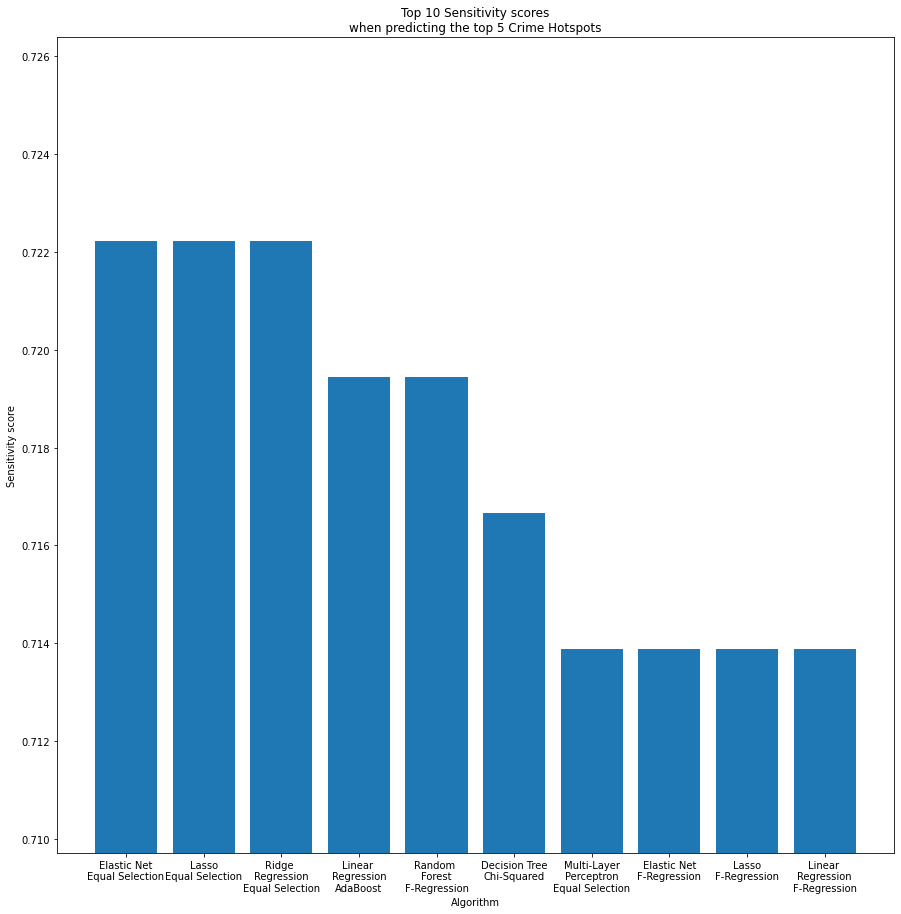

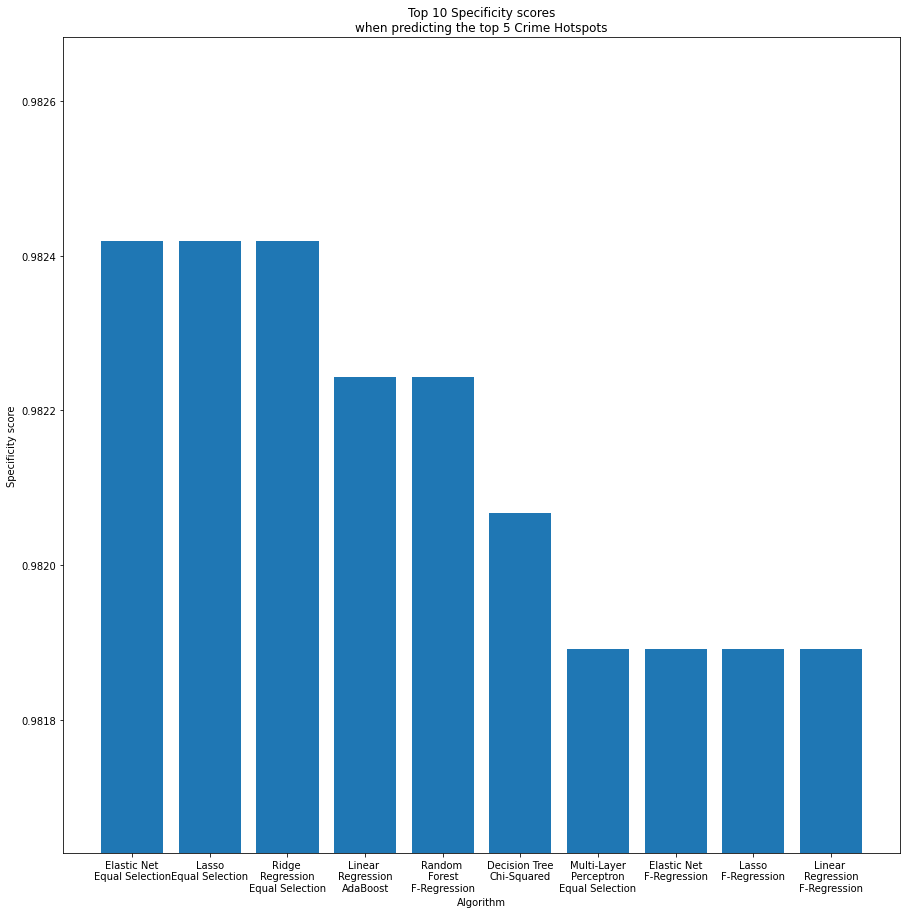

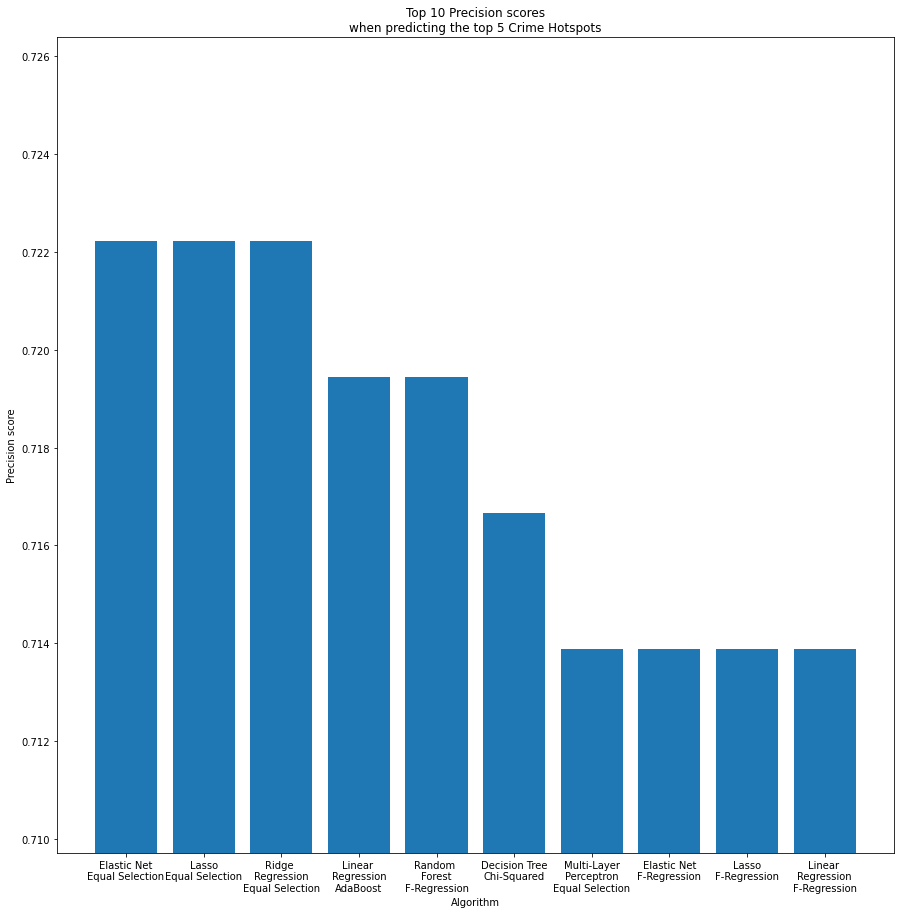

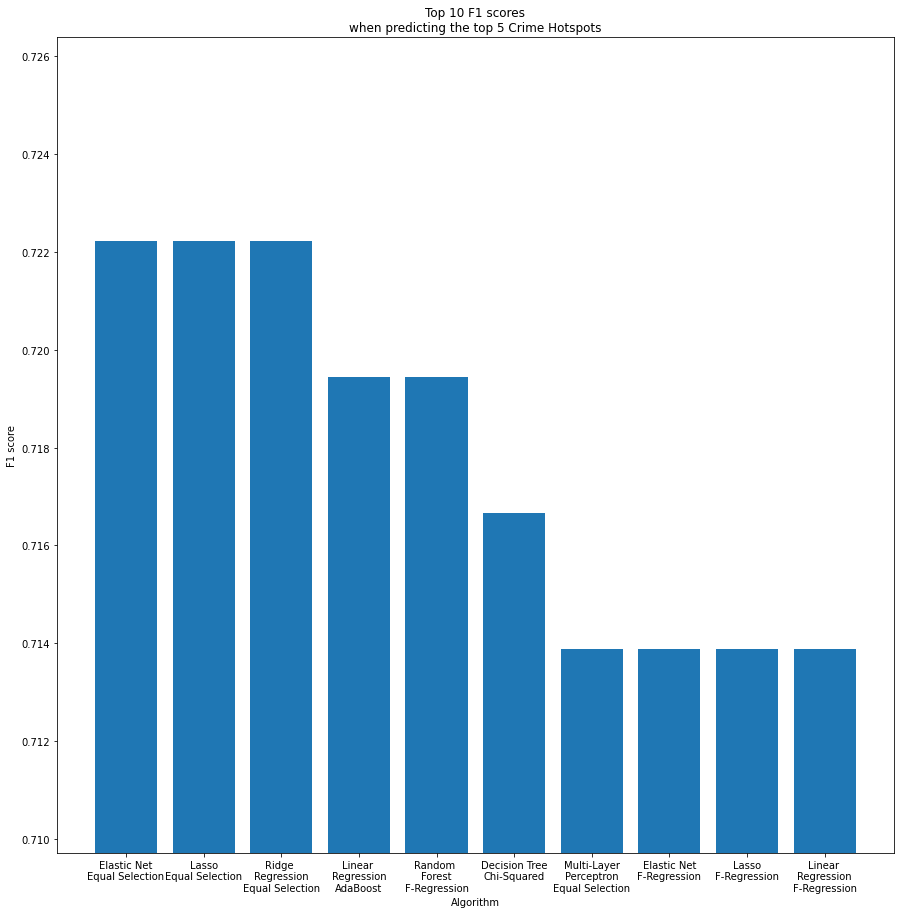

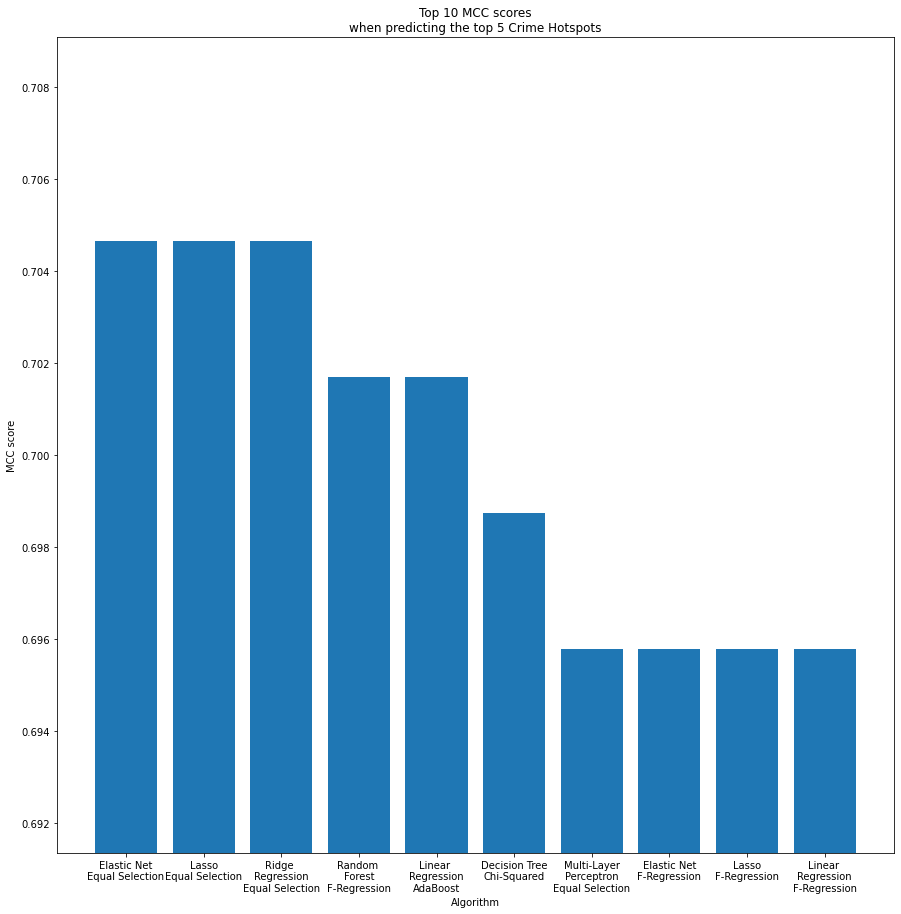

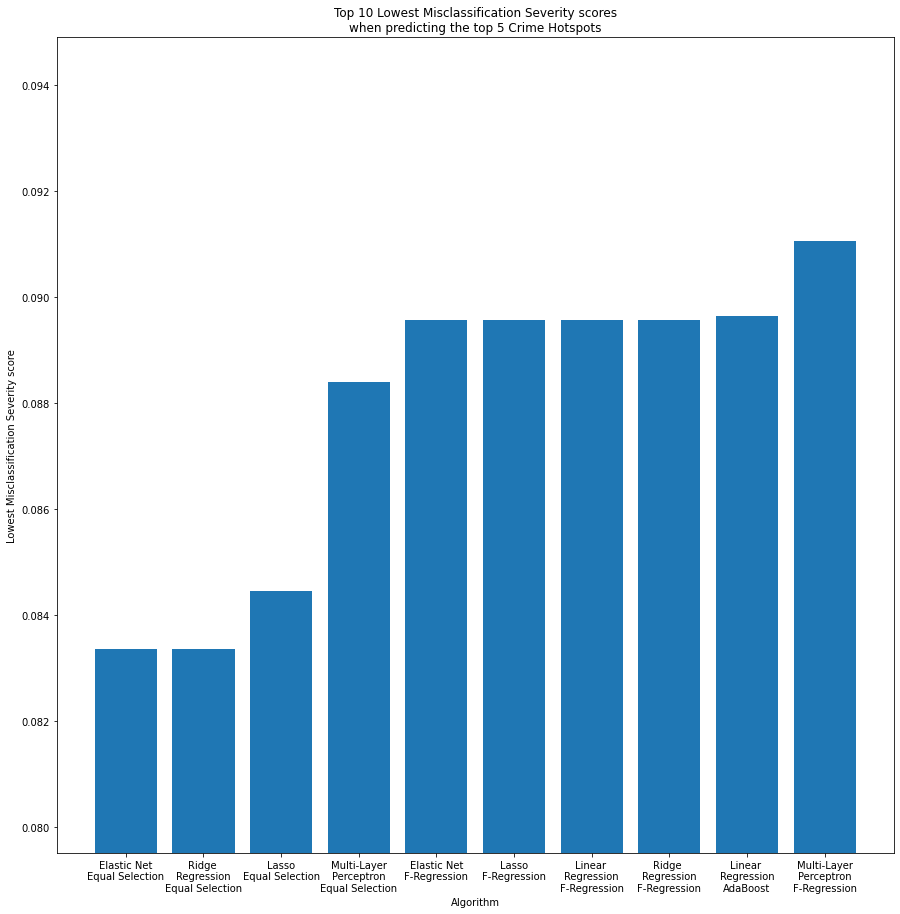

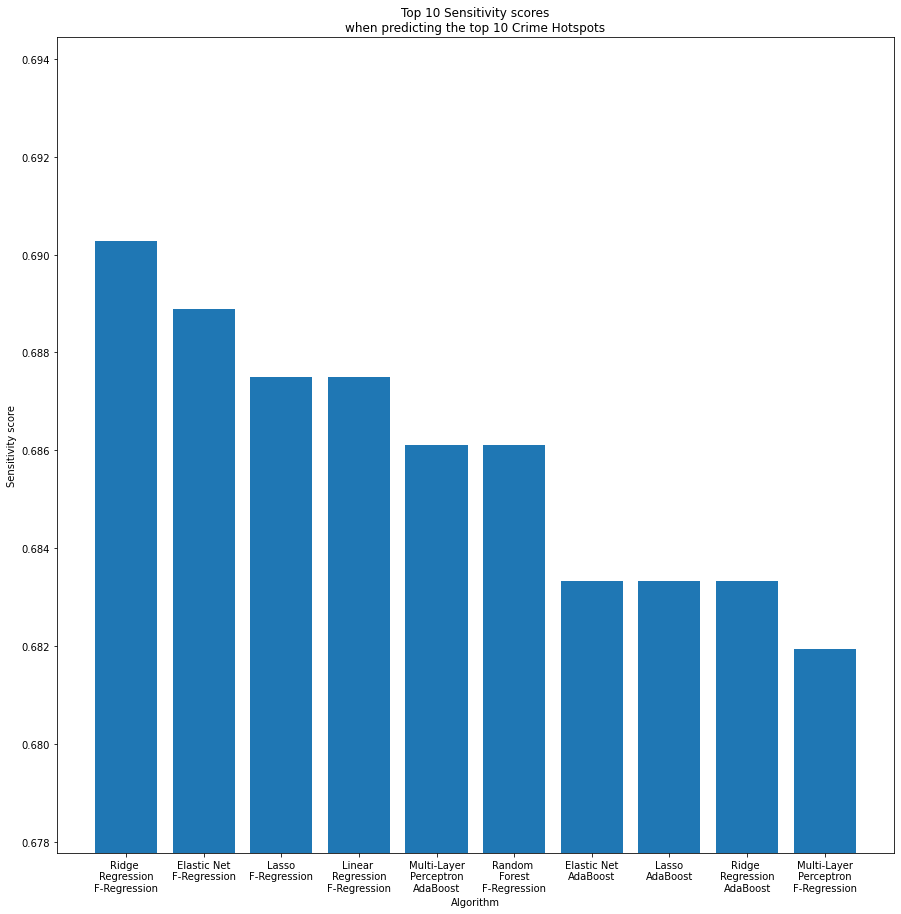

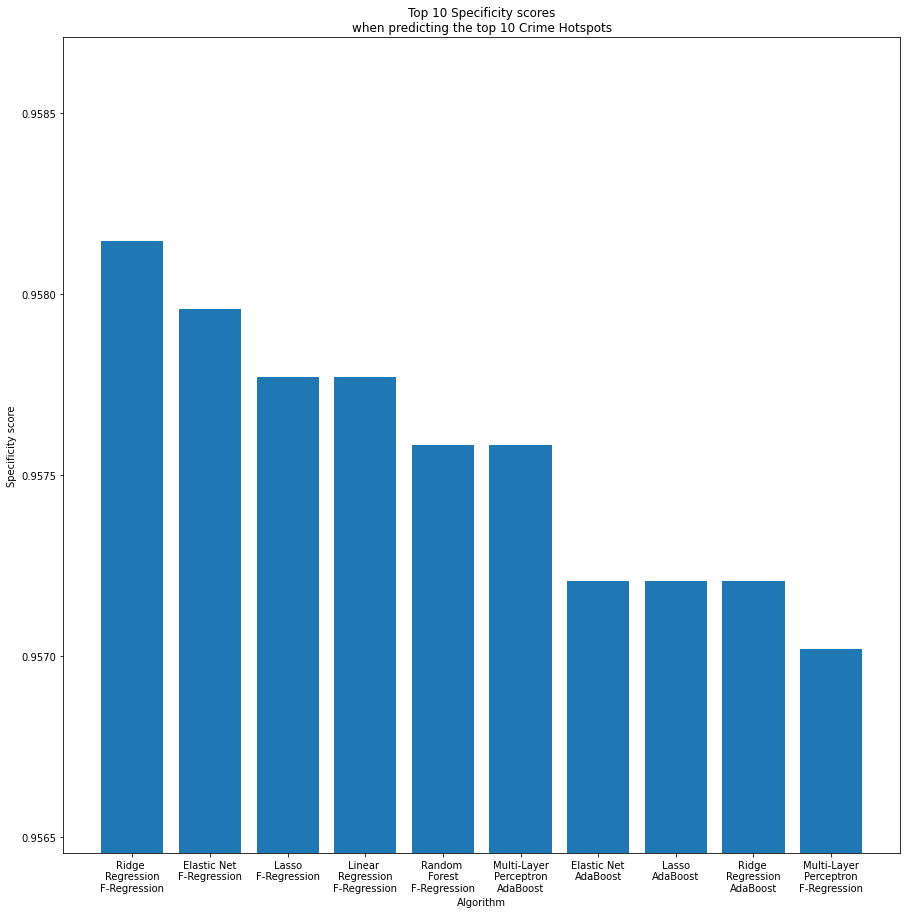

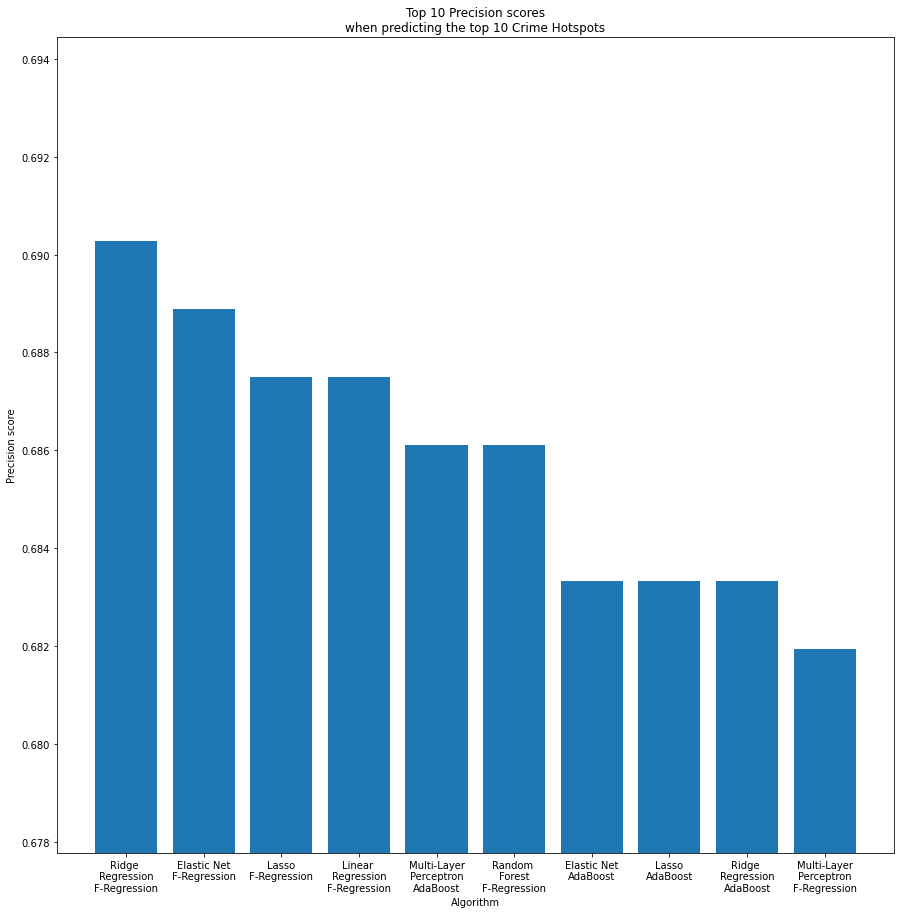

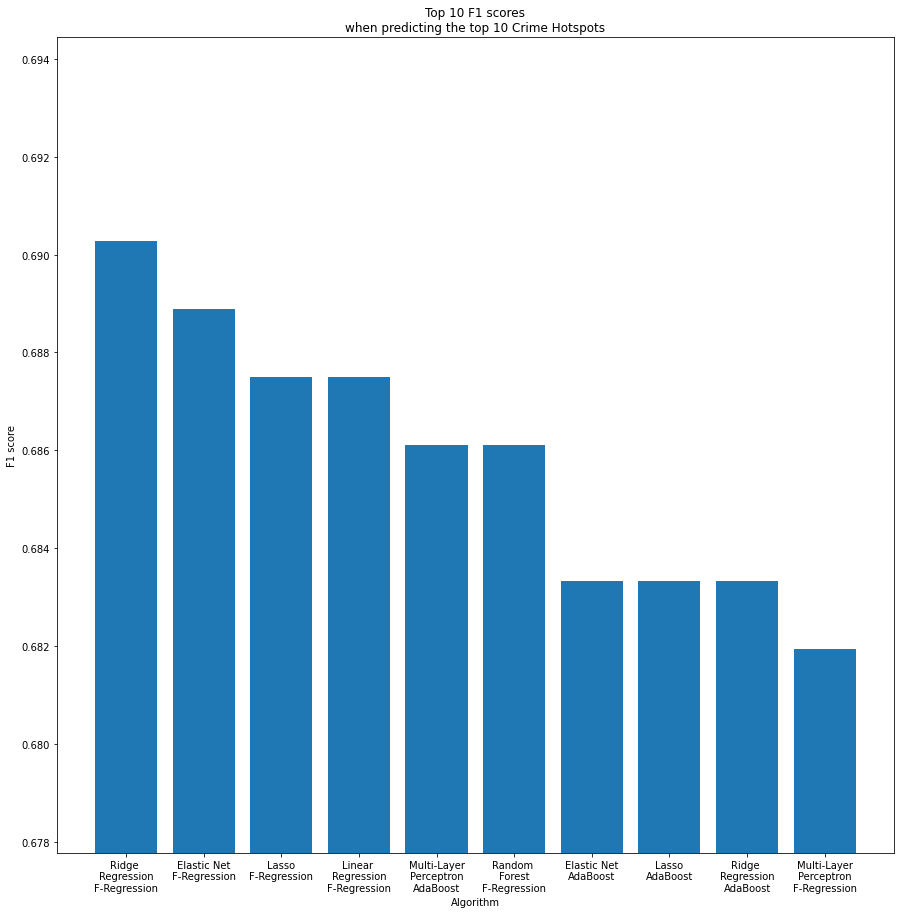

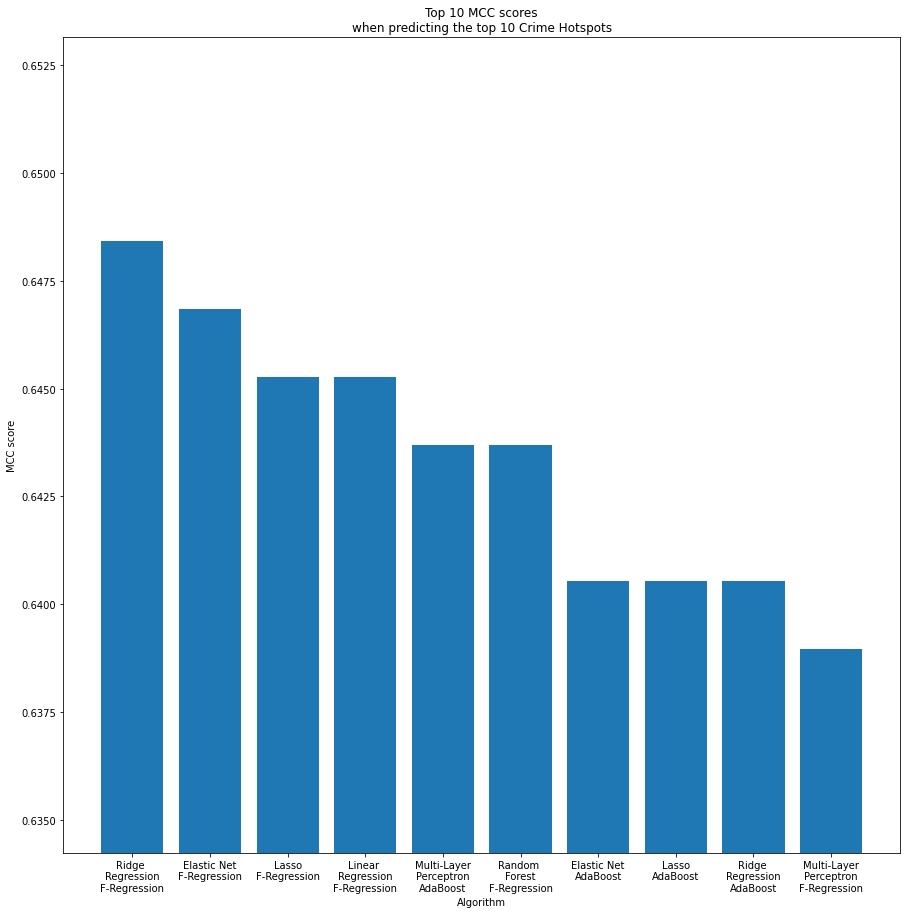

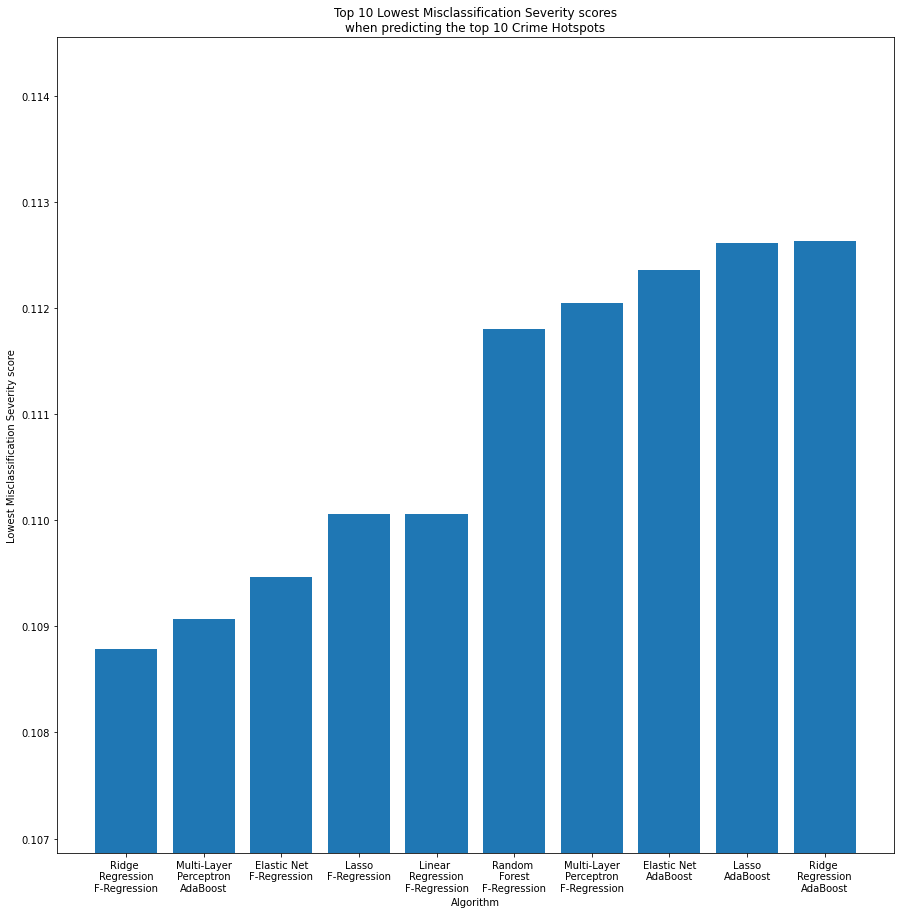

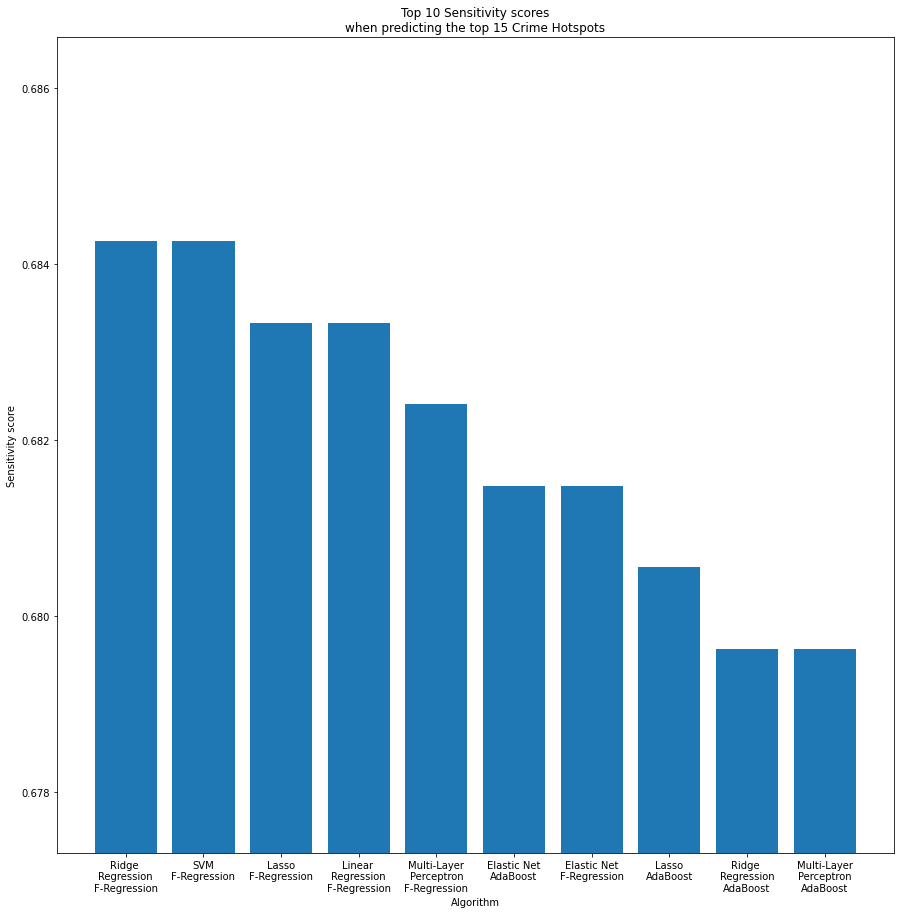

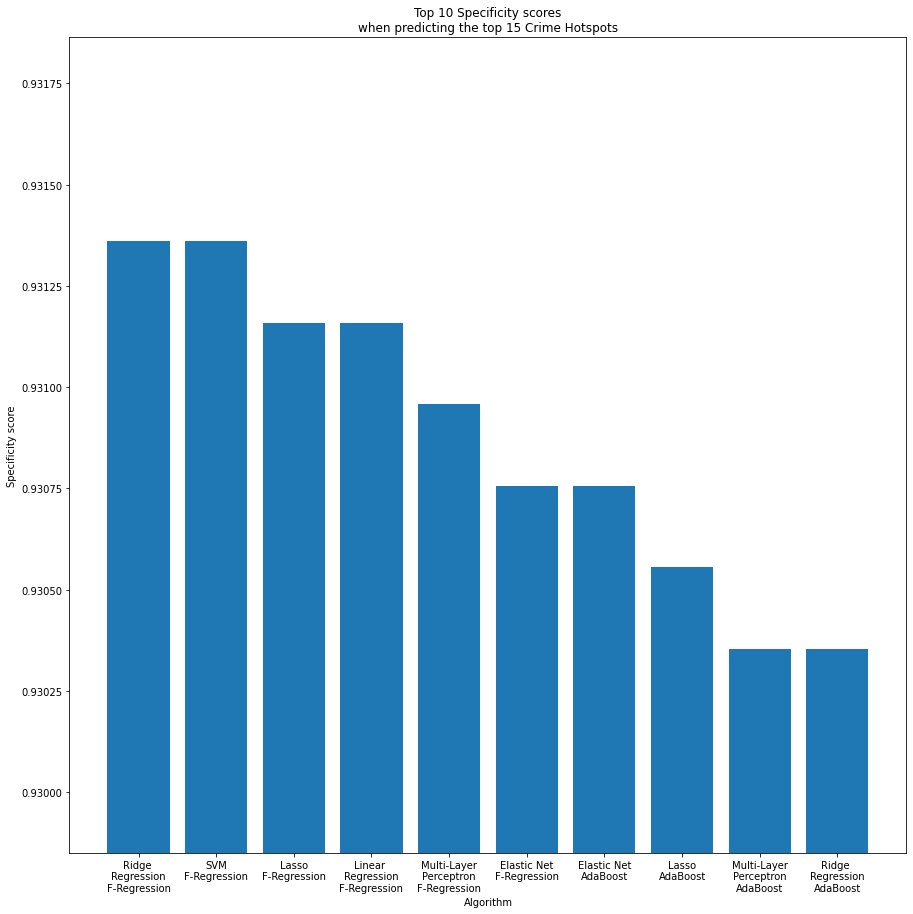

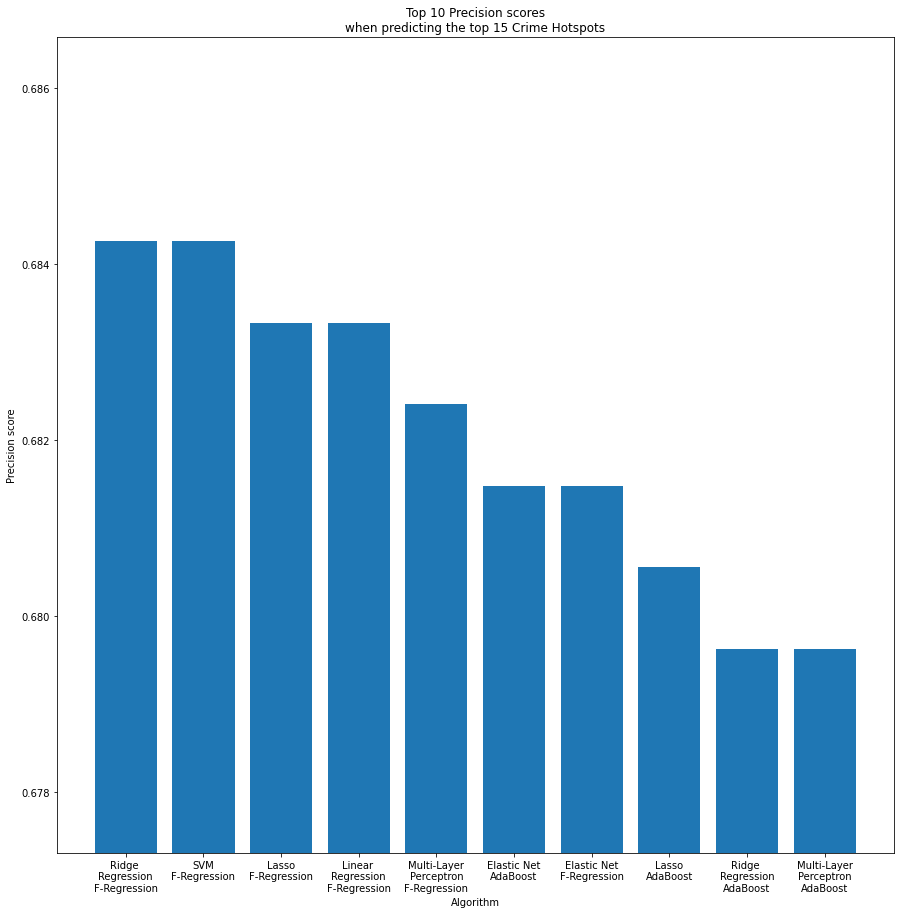

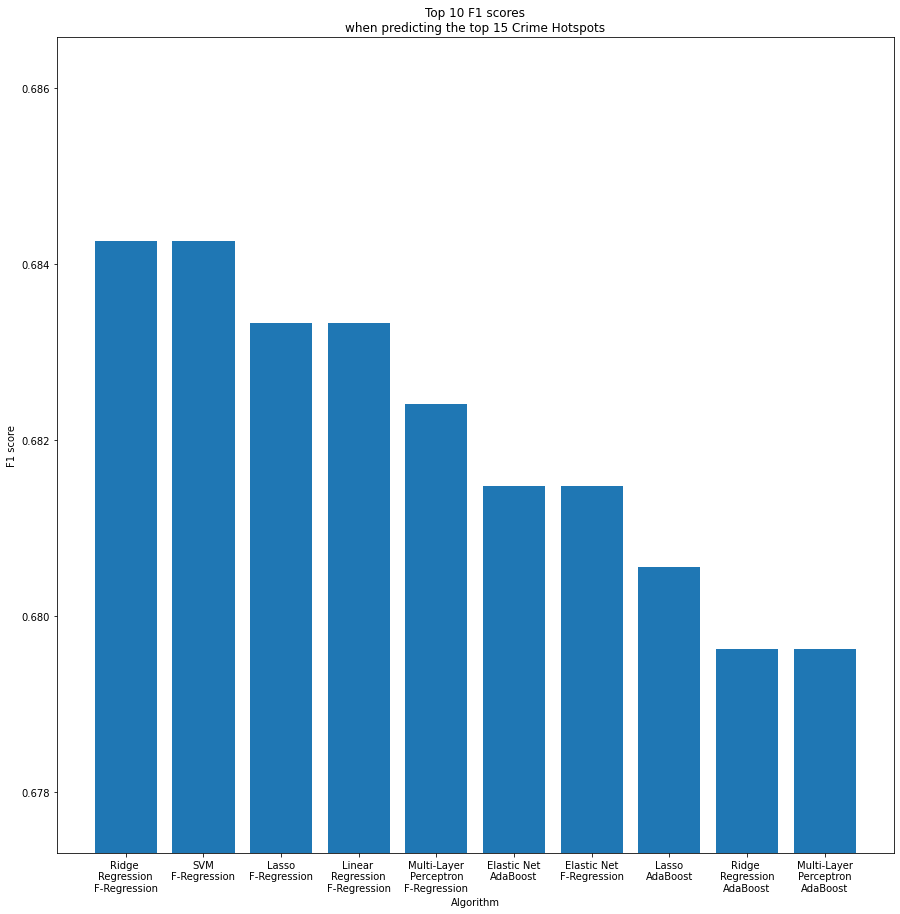

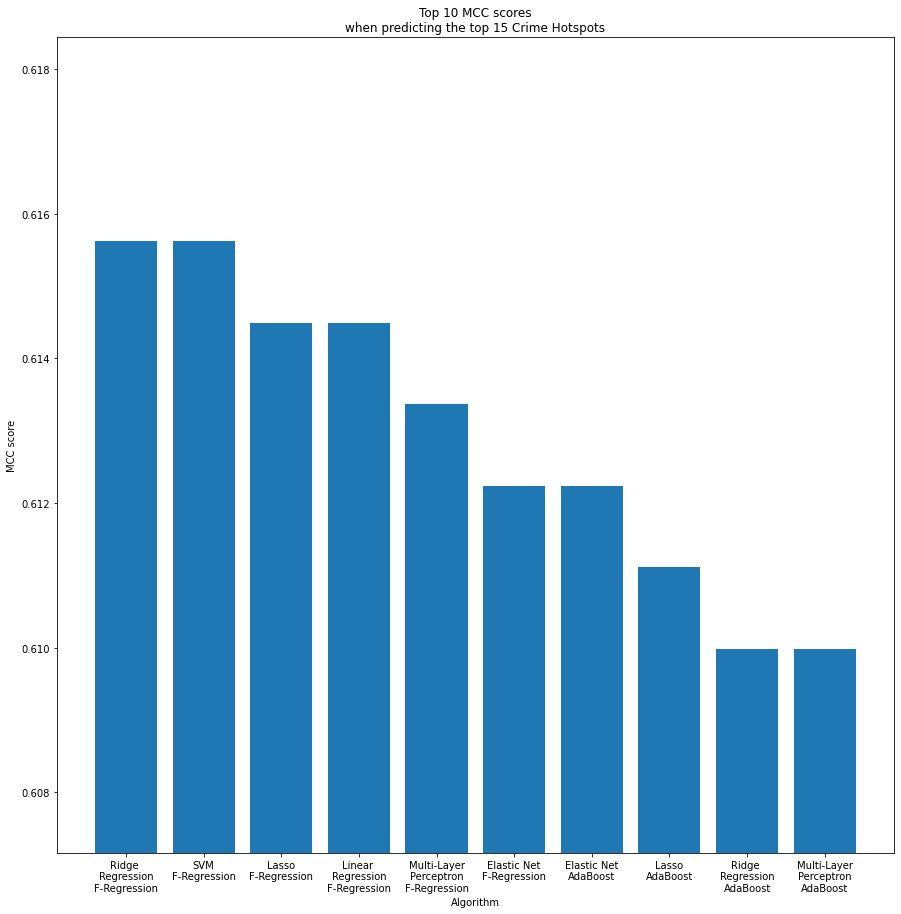

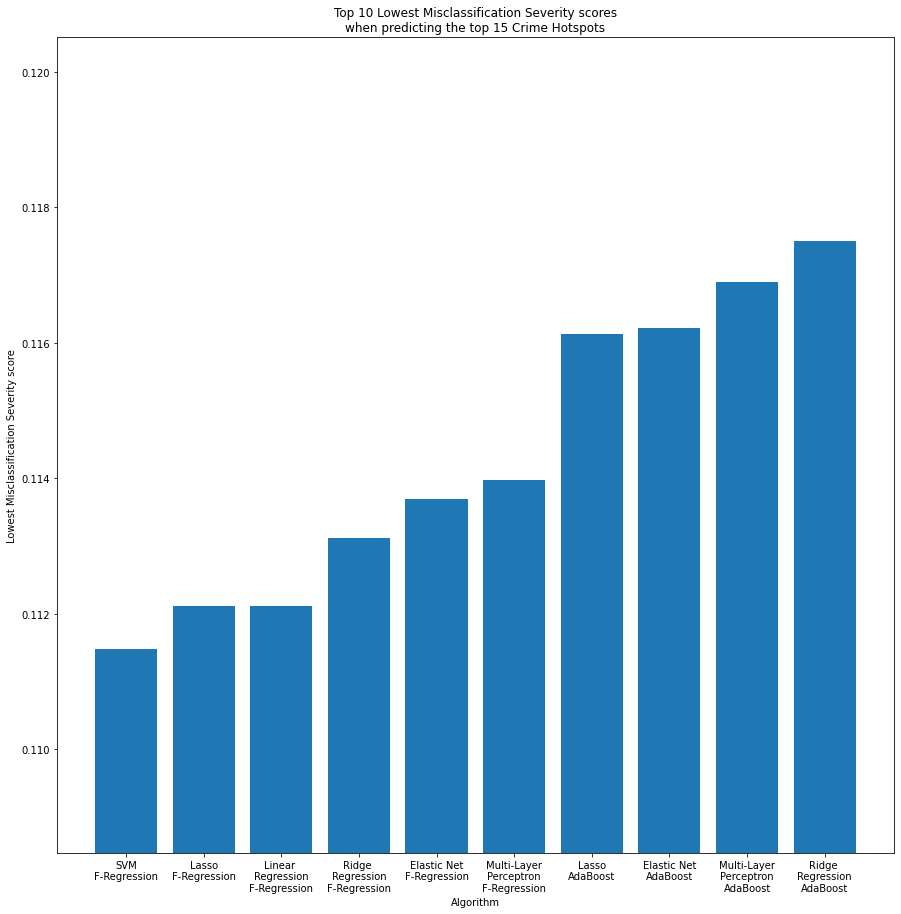

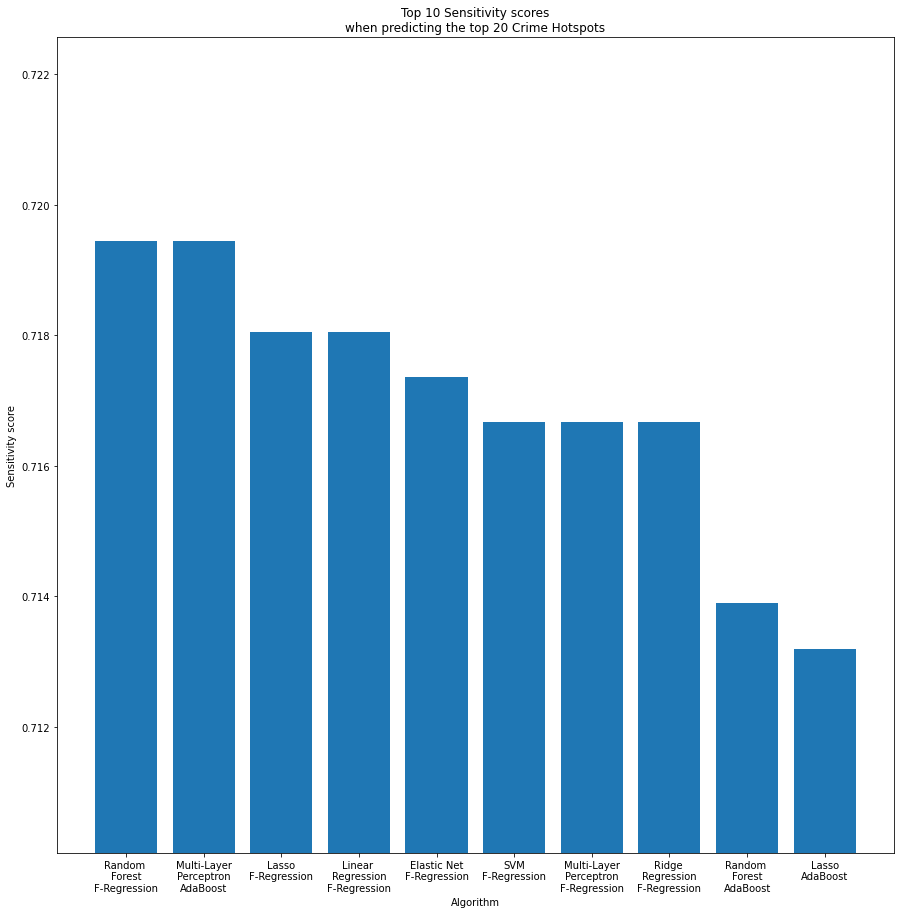

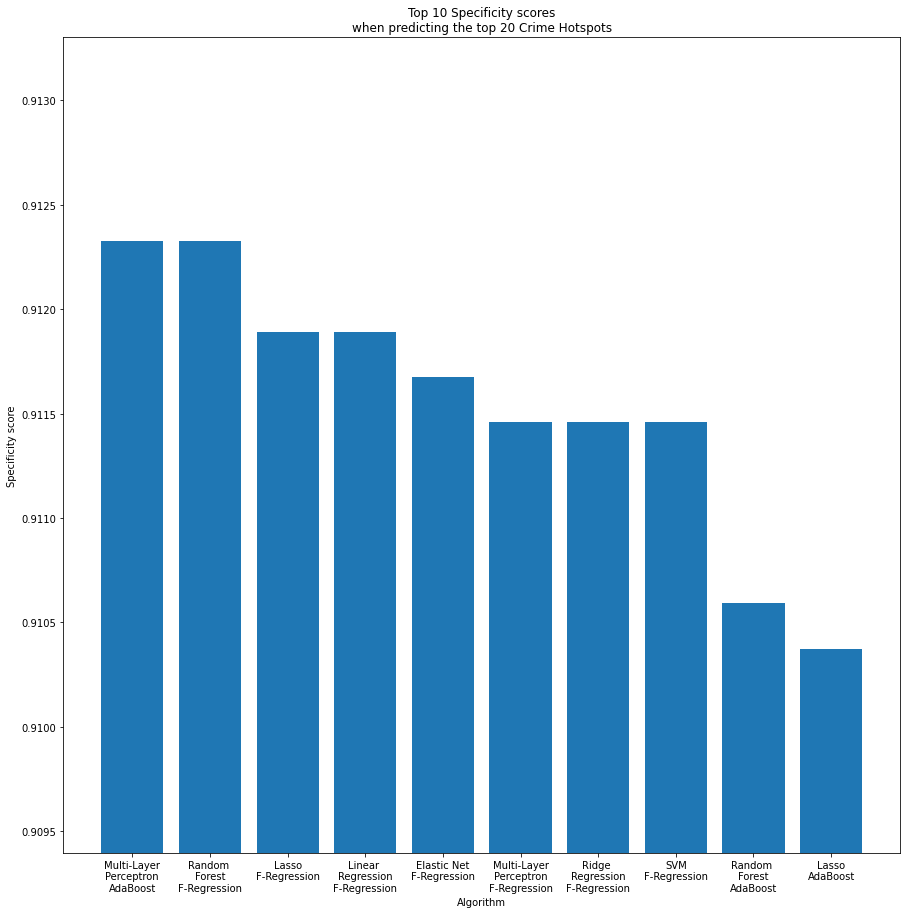

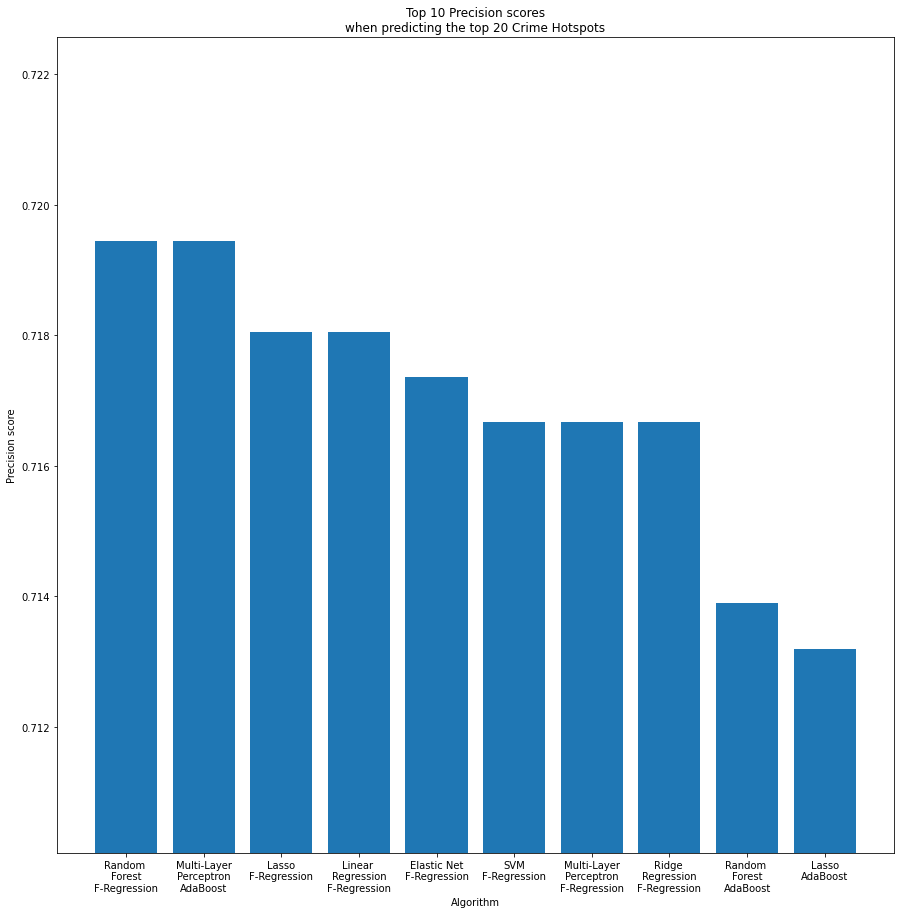

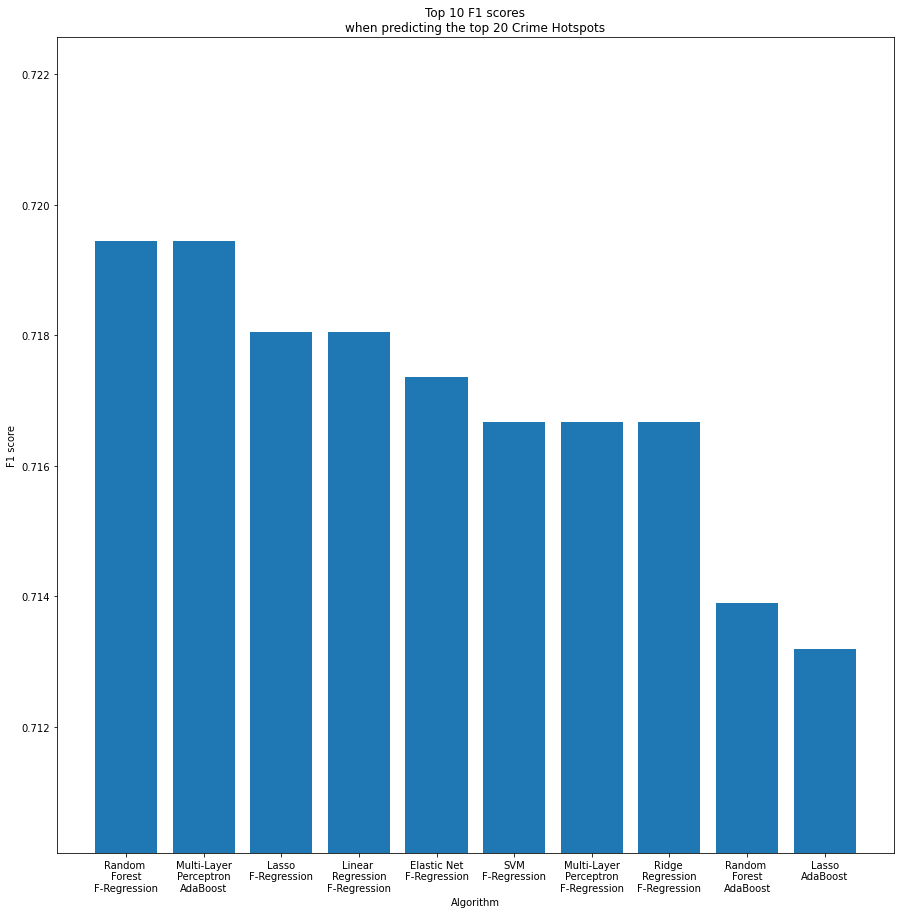

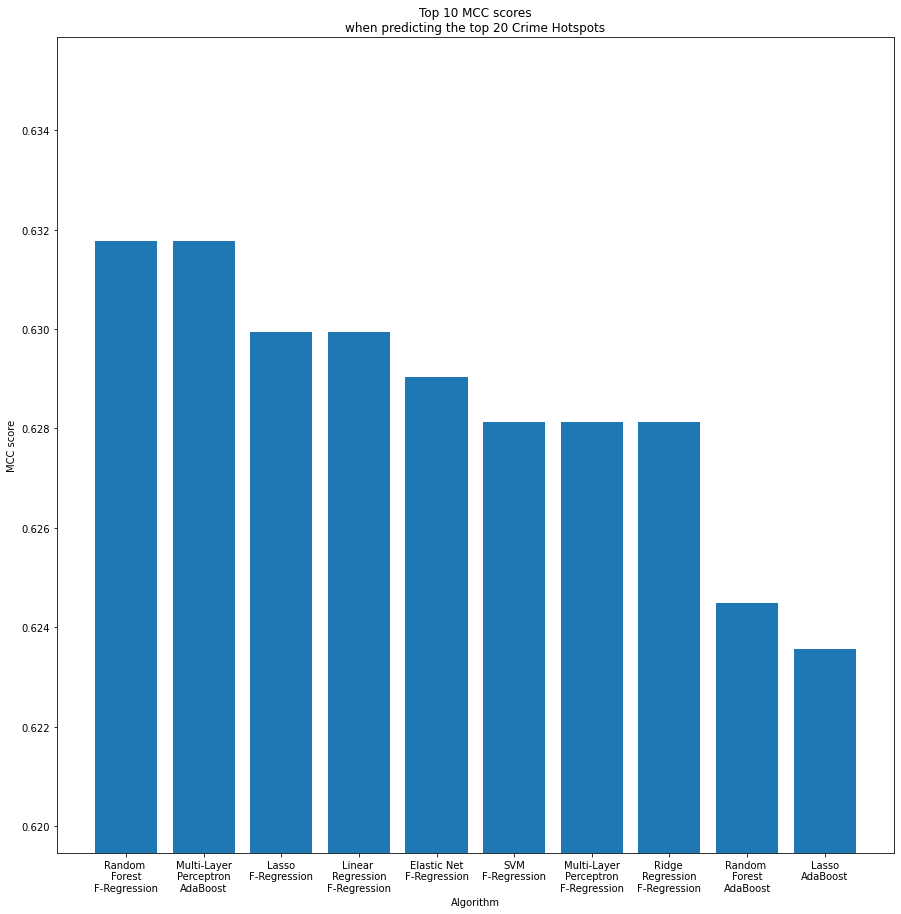

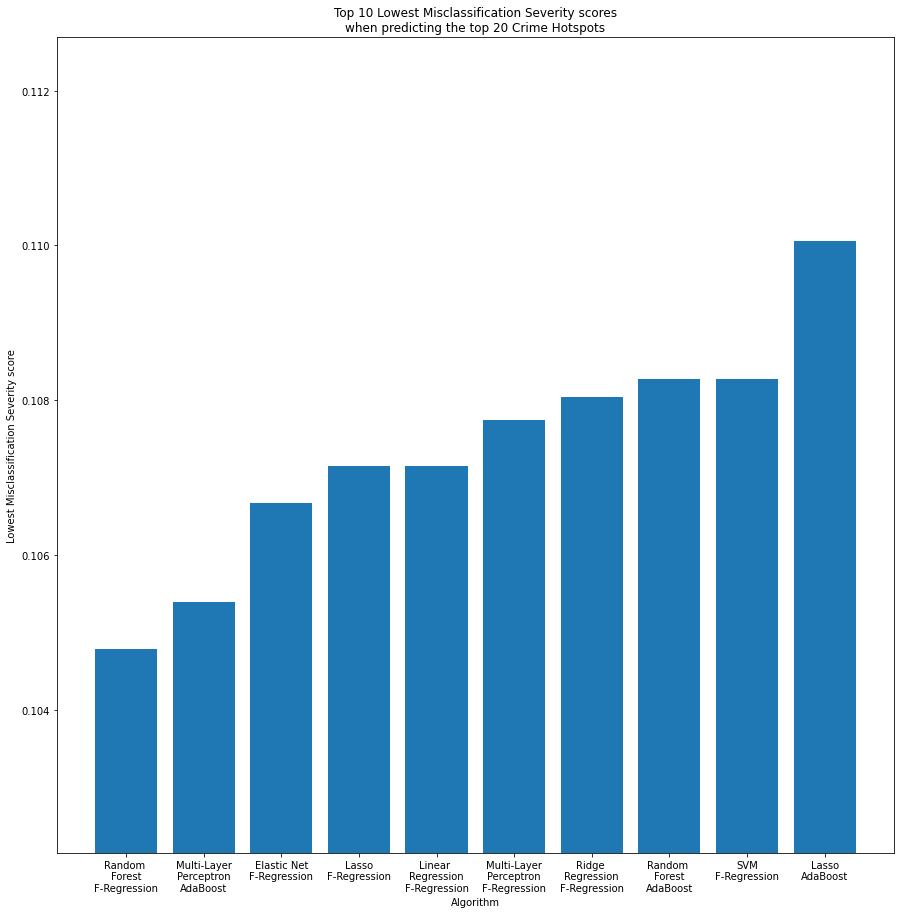

In [23]:
top_x = 10
bars = evaluate_models(num_hotspots_range,top_x)

<h3> Testing starts here <h3>

<h3> Test open_file <h3>

In [24]:
def test_open_file(expected_length,expected_columns):
    df = open_file()
    assert len(df) == expected_length, "Data frame length not as expected."
    actual_columns = df.columns    
    assert len(actual_columns) == len(expected_columns), "Actual columns not as expected."
    for i in range(len(expected_columns)):
        assert expected_columns[i] == actual_columns[i], "Expected column " + expected_columns[i] + " but got " + actual_columns[i]
    print("All tests completed successfully")

In [25]:
def get_all_columns():
    return ['Reports 1 day ago','Reports 2 days ago','Reports 3 days ago','Reports 4 days ago','Reports 5 days ago',
                    'Reports 6 days ago','Reports 7 days ago','Reports 14 days ago','Reports 30 days ago',
                    'Reports 365 days ago','Last 7 days reports','Last 14 days reports','Last 28 days reports',
                    'Number of businesses','Businesses 1 day ago','Businesses 2 days ago','Businesses 3 days ago',
                    'Businesses 4 days ago','Businesses 5 days ago','Businesses 6 days ago','Businesses 7 days ago',
                    'Businesses 14 days ago','Businesses 30 days ago','Businesses 365 days ago','Number of closures',
                    'Closures 1 day ago','Closures 2 days ago','Closures 3 days ago','Closures 4 days ago',
                    'Closures 5 days ago','Closures 6 days ago','Closures 7 days ago','Closures 14 days ago',
                    'Closures 30 days ago','Closures 365 days ago','Last 7 days closures','Last 14 days closures',
                    'Last 28 days closures','Number of openings','Openings 1 day ago','Openings 2 days ago',
                    'Openings 3 days ago','Openings 4 days ago','Openings 5 days ago','Openings 6 days ago',
                    'Openings 7 days ago','Openings 14 days ago','Openings 30 days ago','Openings 365 days ago',
                    'Last 7 days openings','Last 14 days openings','Last 28 days openings','Alamo Square','Anza Vista',
                    'Apparel City','Aquatic Park / Ft. Mason','Balboa Terrace','Bayview','Bernal Heights','Bret Harte',
                    'Buena Vista','Candlestick Point SRA','Castro','Cathedral Hill','Cayuga','Central Waterfront','Chinatown',
                    'Civic Center','Clarendon Heights','Cole Valley','Corona Heights','Cow Hollow','Crocker Amazon',
                    'Diamond Heights','Dogpatch','Dolores Heights','Downtown / Union Square','Duboce Triangle','Eureka Valley',
                    'Excelsior','Fairmount','Financial District','Fishermans Wharf','Forest Hill','Forest Knolls','Glen Park',
                    'Golden Gate Heights','Golden Gate Park','Haight Ashbury','Hayes Valley','Holly Park','Hunters Point',
                    'India Basin','Ingleside','Ingleside Terraces','Inner Richmond','Inner Sunset','Japantown','Laguna Honda',
                    'Lake Street','Lakeshore','Laurel Heights / Jordan Park','Lincoln Park / Ft. Miley','Little Hollywood',
                    'Lone Mountain','Lower Haight','Lower Nob Hill','Lower Pacific Heights','Marina','McLaren Park',
                    'Merced Heights','Merced Manor','Midtown Terrace','Mint Hill','Miraloma Park','Mission','Mission Bay',
                    'Mission Dolores','Mission Terrace','Monterey Heights','Mt. Davidson Manor','Nob Hill','Noe Valley',
                    'North Beach','Northern Waterfront','Oceanview','Outer Mission','Outer Richmond','Outer Sunset',
                    'Pacific Heights','Panhandle','Parkmerced','Parkside','Parnassus Heights','Peralta Heights',
                    'Polk Gulch','Portola','Potrero Hill','Presidio Heights','Presidio National Park','Presidio Terrace',
                    'Produce Market','Rincon Hill','Russian Hill','Seacliff','Sherwood Forest','Showplace Square',
                    'Silver Terrace','South Beach','South of Market','St. Francis Wood','St. Marys Park','Stonestown',
                    'Sunnydale','Sunnyside','Sutro Heights','Telegraph Hill','Tenderloin','Treasure Island','Union Street',
                    'University Mound','Upper Market','Visitacion Valley','West Portal','Western Addition',
                    'Westwood Highlands','Westwood Park','Yerba Buena Island','Friday','Saturday','Sunday','Thursday',
                    'Tuesday','Wednesday','Todays Reports','Date','Neighborhood']

In [26]:
def get_all_neighbourhoods():
    return ['Alamo Square','Anza Vista', 'Apparel City','Aquatic Park / Ft. Mason','Ashbury Heights','Balboa Terrace','Bayview',
            'Bernal Heights','Bret Harte','Buena Vista','Candlestick Point SRA','Castro','Cathedral Hill','Cayuga',
            'Central Waterfront','Chinatown','Civic Center','Clarendon Heights','Cole Valley','Corona Heights','Cow Hollow',
            'Crocker Amazon','Diamond Heights','Dogpatch','Dolores Heights','Downtown / Union Square','Duboce Triangle',
            'Eureka Valley','Excelsior','Fairmount','Financial District','Fishermans Wharf','Forest Hill','Forest Knolls',
            'Glen Park','Golden Gate Heights','Golden Gate Park','Haight Ashbury','Hayes Valley','Holly Park','Hunters Point',
            'India Basin','Ingleside','Ingleside Terraces','Inner Richmond','Inner Sunset','Japantown','Laguna Honda',
            'Lake Street','Lakeshore','Laurel Heights / Jordan Park','Lincoln Park / Ft. Miley','Little Hollywood',
            'Lone Mountain','Lower Haight','Lower Nob Hill','Lower Pacific Heights','Marina','McLaren Park',
            'Merced Heights','Merced Manor','Midtown Terrace','Mint Hill','Miraloma Park','Mission','Mission Bay',
            'Mission Dolores','Mission Terrace','Monterey Heights','Mt. Davidson Manor','Nob Hill','Noe Valley',
            'North Beach','Northern Waterfront','Oceanview','Outer Mission','Outer Richmond','Outer Sunset',
            'Pacific Heights','Panhandle','Parkmerced','Parkside','Parnassus Heights','Peralta Heights',
            'Polk Gulch','Portola','Potrero Hill','Presidio Heights','Presidio National Park','Presidio Terrace',
            'Produce Market','Rincon Hill','Russian Hill','Seacliff','Sherwood Forest','Showplace Square',
            'Silver Terrace','South Beach','South of Market','St. Francis Wood','St. Marys Park','Stonestown',
            'Sunnydale','Sunnyside','Sutro Heights','Telegraph Hill','Tenderloin','Treasure Island','Union Street',
            'University Mound','Upper Market','Visitacion Valley','West Portal','Western Addition',
            'Westwood Highlands','Westwood Park','Yerba Buena Island']

In [27]:
def get_all_ones():
    all_ones = []
    for i in range(0,117):
        all_ones.append(1)
    return all_ones

In [28]:
#test successful load
expected_columns = get_all_columns()
DEFAULT_FILE_PATH = "tuning_test_data"
expected_length = 819
test_open_file(expected_length,expected_columns)

All tests completed successfully


In [29]:
#test failed load
expected_columns = []
DEFAULT_FILE_PATH = "incorrect_path"
expected_length = 0
test_open_file(expected_length,expected_columns)

File not found
All tests completed successfully


<h3> Test get_hotspots <h3>

In [30]:
def test_get_hotspots(test_model_name,test_feature_name,calendar_date, expected_y_actual, expected_actual_neighbourhoods,
                     expected_y_predict, expected_prediction_neighbourhoods):
    data = open_file()
    y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods = get_hotspots(data, 
                                                                                     test_model_name, 
                                                                                     test_feature_name,
                                                                                     calendar_date)
    for i in range(0,len(y_actual)):
        assert y_actual[i] == expected_y_actual[i], "Y actual not as expected."
    for i in range(0,len(expected_y_actual)):
        assert expected_y_actual[i] == y_actual[i], "Y actual not as expected."
        
    for i in range(0,len(y_predict)):
        assert y_predict[i] == expected_y_predict[i], "Y actual not as expected."
    for i in range(0,len(expected_y_predict)):
        assert expected_y_predict[i] == y_predict[i], "Y actual not as expected."   
    for i in range(0,len(actual_neighbourhoods)):
        assert actual_neighbourhoods[i] == expected_actual_neighbourhoods[i], "Actual neighbourhoods not as expected."
    for i in range(0,len(expected_actual_neighbourhoods)):
        assert expected_actual_neighbourhoods[i] == actual_neighbourhoods[i], "Actual neighbourhoods not as expected."    
    for i in range(0,len(prediction_neighbourhoods)):
        assert prediction_neighbourhoods[i] == expected_prediction_neighbourhoods[i], "Predicted neighbourhoods not as expected."  
    for i in range(0,len(expected_prediction_neighbourhoods)):
        assert expected_prediction_neighbourhoods[i] == prediction_neighbourhoods[i], "Predicted neighbourhoods not as expected."
    print("Tests completed successfully")

In [31]:
DEFAULT_FILE_PATH = "tuning_test_data"
test_model_name = "Tuning Template Test"
test_model_file_tag = "tuning_template_test_model"
test_feature_file_tag = "arbitrary_name"
test_feature_name = "Arbitrary Feature Name"
test_feature_features = ['Reports 1 day ago', 'Reports 2 days ago', 'Reports 3 days ago',
                       'Reports 4 days ago', 'Reports 5 days ago', 'Reports 6 days ago',
                      'Reports 7 days ago','Reports 14 days ago','Reports 30 days ago','Reports 365 days ago']
FEATURES[test_feature_name] = test_feature_features
FEATURE_FILE_TAGS[test_feature_name] = test_feature_file_tag
FEATURE_NAMES_BY_FILE_TAG[test_feature_file_tag] = test_feature_name
MODEL_FILE_TAGS[test_model_name] = test_model_file_tag
calendar_date = "05/01/2021"

In [32]:
expected_y_actual = [5, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
expected_actual_neighbourhoods = ['Downtown / Union Square', 'Bernal Heights', 'Western Addition', 'Portola',
 'Bayview', 'Eureka Valley', 'South Beach', 'Lincoln Park / Ft. Miley',
 'Hunters Point', 'Potrero Hill', 'Presidio Heights', 'Cow Hollow',
 'Russian Hill', 'Cole Valley', 'Mission Terrace', 'Hayes Valley',
 'Stonestown', 'Central Waterfront', 'Northern Waterfront', 'Buena Vista',
 'Visitacion Valley', 'North Beach', 'Forest Hill', 'South of Market',
 'Haight Ashbury', 'Golden Gate Park', 'Yerba Buena Island',
 'Golden Gate Heights', 'Ingleside Terraces', 'Inner Richmond',
 'Inner Sunset', 'Lake Street', 'Lakeshore', 'Ingleside', 'Diamond Heights',
 'Glen Park', 'Forest Knolls', 'Financial District', 'Excelsior',
 'Duboce Triangle', 'Crocker Amazon', 'Corona Heights', 'Clarendon Heights',
 'Civic Center', 'Candlestick Point SRA', 'Balboa Terrace', 'Anza Vista',
 'Laurel Heights / Jordan Park', 'Merced Manor', 'Little Hollywood',
 'St. Francis Wood', 'Panhandle', 'Parkside', 'Presidio National Park',
 'Seacliff', 'Sherwood Forest', 'Silver Terrace', 'Sunnyside', 'Outer Sunset',
 'Telegraph Hill', 'Tenderloin', 'Treasure Island', 'Upper Market',
 'West Portal', 'Westwood Highlands', 'Pacific Heights', 'Outer Richmond',
 'Lone Mountain', 'Mission', 'Lower Pacific Heights', 'Marina',
 'Merced Heights', 'Westwood Park', 'Midtown Terrace', 'Miraloma Park',
 'Mission Bay', 'Outer Mission', 'Mission Dolores', 'Monterey Heights',
 'Mt. Davidson Manor', 'Nob Hill', 'Noe Valley', 'Oceanview', 'Alamo Square']
expected_y_predict = expected_y_actual
expected_prediction_neighbourhoods = expected_actual_neighbourhoods
test_get_hotspots(test_model_name,test_feature_name,calendar_date, expected_y_actual, expected_actual_neighbourhoods,
                     expected_y_predict, expected_prediction_neighbourhoods)

Tests completed successfully


<h3> Test load_model <h3>

In [33]:
def test_load_model(x_data, y_data, neighbourhoods_data, model_key, features_key):
    y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods = load_model(x_data, 
                                                                                       y_data, 
                                                                                       neighbourhoods_data,
                                                                                       model_key, 
                                                                                       features_key)
    for i in range(0,len(y_actual)):
        assert y_actual[i] == expected_y_actual[i], "Y actual not as expected."
    for i in range(0,len(expected_y_actual)):
        assert expected_y_actual[i] == y_actual[i], "Y actual not as expected."   
    for i in range(0,len(y_predict)):
        assert y_predict[i] == expected_y_predict[i], "Y actual not as expected."
    for i in range(0,len(expected_y_predict)):
        assert expected_y_predict[i] == y_predict[i], "Y actual not as expected."   
    for i in range(0,len(actual_neighbourhoods)):
        assert actual_neighbourhoods[i] == expected_actual_neighbourhoods[i], "Actual neighbourhoods not as expected."
    for i in range(0,len(expected_actual_neighbourhoods)):
        assert expected_actual_neighbourhoods[i] == actual_neighbourhoods[i], "Actual neighbourhoods not as expected."    
    for i in range(0,len(prediction_neighbourhoods)):
        assert prediction_neighbourhoods[i] == expected_prediction_neighbourhoods[i], "Predicted neighbourhoods not as expected."  
    for i in range(0,len(expected_prediction_neighbourhoods)):
        assert expected_prediction_neighbourhoods[i] == prediction_neighbourhoods[i], "Predicted neighbourhoods not as expected."
    print("Tests completed successfully")

In [34]:
all_ones = get_all_ones()
x_columns = ['Reports 1 day ago','Reports 2 days ago','Reports 3 days ago','Reports 4 days ago',
                      'Reports 5 days ago','Reports 6 days ago','Reports 7 days ago','Reports 14 days ago',
                      'Reports 30 days ago','Reports 365 days ago']
x_data = pd.DataFrame()
for col in x_columns:
    x_data[col] = all_ones
y_data = pd.DataFrame()
y_data['Todays Reports'] = all_ones
neighbourhoods_data = pd.DataFrame()
neighbourhoods_data['Neighborhood'] = get_all_neighbourhoods()
model_key = 'Tuning Template Test'
features_key = 'Arbitrary Feature Name'
test_load_model(x_data, y_data, neighbourhoods_data, model_key, features_key)

Tests completed successfully


<h3> Test make_prediction <h3>

In [35]:
def test_make_prediction(model_path, x_data, y_data, neighbourhoods_data):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods = make_prediction(model,
                                                                                            x_data, 
                                                                                            y_data, 
                                                                                            neighbourhoods_data)
    for i in range(0,len(y_actual)):
        assert y_actual[i] == expected_y_actual[i], "Y actual not as expected."
    for i in range(0,len(expected_y_actual)):
        assert expected_y_actual[i] == y_actual[i], "Y actual not as expected."   
    for i in range(0,len(y_predict)):
        assert y_predict[i] == expected_y_predict[i], "Y actual not as expected."
    for i in range(0,len(expected_y_predict)):
        assert expected_y_predict[i] == y_predict[i], "Y actual not as expected."   
    for i in range(0,len(actual_neighbourhoods)):
        assert actual_neighbourhoods[i] == expected_actual_neighbourhoods[i], "Actual neighbourhoods not as expected."
    for i in range(0,len(expected_actual_neighbourhoods)):
        assert expected_actual_neighbourhoods[i] == actual_neighbourhoods[i], "Actual neighbourhoods not as expected."    
    for i in range(0,len(prediction_neighbourhoods)):
        assert prediction_neighbourhoods[i] == expected_prediction_neighbourhoods[i], "Predicted neighbourhoods not as expected."  
    for i in range(0,len(expected_prediction_neighbourhoods)):
        assert expected_prediction_neighbourhoods[i] == prediction_neighbourhoods[i], "Predicted neighbourhoods not as expected."
    print("Tests completed successfully")

In [36]:
model_path = "CrimeGUI/Models/tuning_template_test_model_arbitrary_name"
test_make_prediction(model_path,x_data, y_data, neighbourhoods_data)

Tests completed successfully


<h3> Test get non negative value <h3>

In [37]:
def test_get_non_negative_value(nums_in,expected_outs):
    for i in range(0,len(nums_in)):
        result = get_non_negative_value(nums_in[i])
        assert result == expected_outs[i], "Returned value not as expected"
    print("Tests completed successfully.")

In [38]:
nums_in = [-10,-2,-1,0,1,2,10]
expected_outs = [0,0,0,0,1,2,10]
test_get_non_negative_value(nums_in,expected_outs)

Tests completed successfully.


<h3> Test merge sub neighbourhoods <h3>

In [39]:
def test_merge_sub_neighbourhoods(y_data_in,y_predict_in,neighbourhoods_data_in, expected_y_actual, expected_y_predict,
                                 expected_neighbourhoods_data):
    y_actual,y_predict,neighbourhoods_data = merge_sub_neighbourhoods(y_data_in,y_predict_in,neighbourhoods_data_in)
    neighbourhoods_data.reset_index(drop=True, inplace=True)
    for i in range(0,len(y_actual)):
        assert y_actual[i] == expected_y_actual[i], "Y actual not as expected."
    for i in range(0,len(expected_y_actual)):
        assert expected_y_actual[i] == y_actual[i], "Y actual not as expected."   
    for i in range(0,len(y_predict)):
        assert y_predict[i] == expected_y_predict[i], "Y actual not as expected."
    for i in range(0,len(expected_y_predict)):
        assert expected_y_predict[i] == y_predict[i], "Y actual not as expected." 
    for i in range(0,len(neighbourhoods_data)):
        assert neighbourhoods_data['Neighborhood'][i] == expected_neighbourhoods_data[i], "Neighbourhoods not as expected."
    for i in range(0,len(expected_neighbourhoods_data)):
        assert expected_neighbourhoods_data[i] == neighbourhoods_data['Neighborhood'][i], "Neighbourhoods not as expected."   
    print("Tests completed successfully")

In [40]:
y_data_in = pd.DataFrame()
y_data_in['Todays Reports'] = get_all_ones()
y_predict_in = all_ones
neighbourhoods_data_in = pd.DataFrame()
neighbourhoods_data_in['Neighborhood'] = get_all_neighbourhoods()
expected_y_actual = [1, 1, 1, 3, 4, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 5, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 
                     2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 1, 2, 1, 1, 1, 2,
                     2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1]
expected_y_predict = expected_y_actual
expected_neighbourhoods_data = ['Alamo Square', 'Anza Vista', 'Balboa Terrace', 'Bayview', 'Bernal Heights', 'Buena Vista', 
                                'Candlestick Point SRA', 'Central Waterfront', 'Civic Center', 'Clarendon Heights', 
                                'Cole Valley', 'Corona Heights', 'Cow Hollow', 'Crocker Amazon', 'Diamond Heights', 
                                'Downtown / Union Square', 'Duboce Triangle', 'Eureka Valley', 'Excelsior', 
                                'Financial District', 'Forest Hill', 'Forest Knolls', 'Glen Park', 'Golden Gate Heights', 
                                'Golden Gate Park', 'Haight Ashbury', 'Hayes Valley', 'Hunters Point', 'Ingleside', 
                                'Ingleside Terraces', 'Inner Richmond', 'Inner Sunset', 'Lake Street', 'Lakeshore', 
                                'Laurel Heights / Jordan Park', 'Lincoln Park / Ft. Miley', 'Little Hollywood', 
                                'Lone Mountain', 'Lower Pacific Heights', 'Marina', 'Merced Heights', 'Merced Manor', 
                                'Midtown Terrace', 'Miraloma Park', 'Mission', 'Mission Bay', 'Mission Dolores', 
                                'Mission Terrace', 'Monterey Heights', 'Mt. Davidson Manor', 'Nob Hill', 'Noe Valley', 
                                'North Beach', 'Northern Waterfront', 'Oceanview', 'Outer Mission', 'Outer Richmond', 
                                'Outer Sunset', 'Pacific Heights', 'Panhandle', 'Parkside', 'Portola', 'Potrero Hill', 
                                'Presidio Heights', 'Presidio National Park', 'Russian Hill', 'Seacliff', 'Sherwood Forest', 
                                'Silver Terrace', 'South Beach', 'South of Market', 'St. Francis Wood', 'Stonestown', 
                                'Sunnyside', 'Telegraph Hill', 'Tenderloin', 'Treasure Island', 'Upper Market', 
                                'Visitacion Valley', 'West Portal', 'Western Addition', 'Westwood Highlands', 'Westwood Park', 
                                'Yerba Buena Island']
test_merge_sub_neighbourhoods(y_data_in,y_predict_in,neighbourhoods_data_in, expected_y_actual, expected_y_predict,
                                 expected_neighbourhoods_data)

Tests completed successfully


<h3> Test calculate accuracy <h3>

In [41]:
data = open_file()
test_model_name = "Tuning Template Test"
test_feature_name = "Arbitrary Feature Name"
calendar_date = "05/01/2021"
y_actual, actual_neighbourhoods, y_predict, prediction_neighbourhoods = get_hotspots(data, 
                                                                                     test_model_name, 
                                                                                     test_feature_name,
                                                                                     calendar_date)

In [42]:
y_actual

array([5, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [43]:
actual_neighbourhoods

array(['Downtown / Union Square', 'Bernal Heights', 'Western Addition',
       'Portola', 'Bayview', 'Eureka Valley', 'South Beach',
       'Lincoln Park / Ft. Miley', 'Hunters Point', 'Potrero Hill',
       'Presidio Heights', 'Cow Hollow', 'Russian Hill', 'Cole Valley',
       'Mission Terrace', 'Hayes Valley', 'Stonestown',
       'Central Waterfront', 'Northern Waterfront', 'Buena Vista',
       'Visitacion Valley', 'North Beach', 'Forest Hill',
       'South of Market', 'Haight Ashbury', 'Golden Gate Park',
       'Yerba Buena Island', 'Golden Gate Heights', 'Ingleside Terraces',
       'Inner Richmond', 'Inner Sunset', 'Lake Street', 'Lakeshore',
       'Ingleside', 'Diamond Heights', 'Glen Park', 'Forest Knolls',
       'Financial District', 'Excelsior', 'Duboce Triangle',
       'Crocker Amazon', 'Corona Heights', 'Clarendon Heights',
       'Civic Center', 'Candlestick Point SRA', 'Balboa Terrace',
       'Anza Vista', 'Laurel Heights / Jordan Park', 'Merced Manor',
       'Li

In [44]:
y_predict

array([5., 4., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [45]:
prediction_neighbourhoods

array(['Downtown / Union Square', 'Bernal Heights', 'Western Addition',
       'Portola', 'Bayview', 'Eureka Valley', 'South Beach',
       'Lincoln Park / Ft. Miley', 'Hunters Point', 'Potrero Hill',
       'Presidio Heights', 'Cow Hollow', 'Russian Hill', 'Cole Valley',
       'Mission Terrace', 'Hayes Valley', 'Stonestown',
       'Central Waterfront', 'Northern Waterfront', 'Buena Vista',
       'Visitacion Valley', 'North Beach', 'Forest Hill',
       'South of Market', 'Haight Ashbury', 'Golden Gate Park',
       'Yerba Buena Island', 'Golden Gate Heights', 'Ingleside Terraces',
       'Inner Richmond', 'Inner Sunset', 'Lake Street', 'Lakeshore',
       'Ingleside', 'Diamond Heights', 'Glen Park', 'Forest Knolls',
       'Financial District', 'Excelsior', 'Duboce Triangle',
       'Crocker Amazon', 'Corona Heights', 'Clarendon Heights',
       'Civic Center', 'Candlestick Point SRA', 'Balboa Terrace',
       'Anza Vista', 'Laurel Heights / Jordan Park', 'Merced Manor',
       'Li

In [46]:
result = calculate_accuracy(y_actual, neighbourhoods, y_actual, neighbourhoods,10)

NameError: name 'neighbourhoods' is not defined

In [ ]:
print(result)